In [1]:
import gensim #pip install gensim
import pprint
from gensim import corpora, models
from gensim.models import LdaModel, LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from nltk.tokenize import word_tokenize
import numpy as np #pip install numpy
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import logging
import pyLDAvis.gensim #pip install pyLDAvis
import pyLDAvis.gensim_models
import time
from prettytable import PrettyTable, ALL #pip install PrettyTable
print(np.__version__)

''' 
 default_term_info = default_term_info.sort_values(
        by='saliency', ascending=False).head(R).drop(labels='saliency', axis=1) #FIX pyLDAVIS
'''

1.26.1


" \n default_term_info = default_term_info.sort_values(\n        by='saliency', ascending=False).head(R).drop(labels='saliency', axis=1) #FIX pyLDAVIS\n"

In [2]:
#1. Creazione del TF-IDF (Term Frequency - Inverse Document Frequency), assegnamo un peso ad ogni parola
#  - TF: frequenza del termine nel documento: num. occorrenze / num. totale di parole nel documento
#  - IDF: inverso della frequenza del termine nei documenti: log(num. totale di documenti / num. documenti che contengono il termine)
#  - TF-IDF: prodotto delle due precedenti (risulta elevato quando la parola è molto presente nel documento e poco presente negli altri documenti)

source = './doc/cleaned.csv'
df = pd.read_csv(source)

#Tokenizzazione
tweets = df['lemmatized_text'].apply(lambda text: word_tokenize(text))

# Create a dictionary
dictionary = corpora.Dictionary(tweets)

# Create a corpus
corpus = [dictionary.doc2bow(doc) for doc in tweets]

# Train the TF-IDF model
tfidf = models.TfidfModel(corpus)

# Transform the corpus into TF-IDF vectors
tfidf_corpus = tfidf[corpus]

In [3]:
# Show some results
for i, doc in enumerate(tfidf_corpus):
    if i > 1:
        break
    print(f"TF-IDF values for document {i}:")
    for token_id, tfidf_value in doc:
        word = dictionary[token_id]  # Get the word corresponding to the token_id
        print(f"Token ID: {token_id}, Word: {word}, TF-IDF Value: {tfidf_value}")
    print("\n")

TF-IDF values for document 0:
Token ID: 0, Word: allegedly, TF-IDF Value: 0.12172989758275168
Token ID: 1, Word: atomic, TF-IDF Value: 0.1634823533125282
Token ID: 2, Word: ban, TF-IDF Value: 0.08655558351002021
Token ID: 3, Word: beijing, TF-IDF Value: 0.13310445728329873
Token ID: 4, Word: bloomberg, TF-IDF Value: 0.1542898494173349
Token ID: 5, Word: briefcase, TF-IDF Value: 0.20824116373793852
Token ID: 6, Word: carrying, TF-IDF Value: 0.13378329113794132
Token ID: 7, Word: chemical, TF-IDF Value: 0.13061197716703943
Token ID: 8, Word: come, TF-IDF Value: 0.0725474152860395
Token ID: 9, Word: conducted, TF-IDF Value: 0.14241856339194872
Token ID: 10, Word: decade, TF-IDF Value: 0.09111724804433256
Token ID: 11, Word: established, TF-IDF Value: 0.1384742945275382
Token ID: 12, Word: explosion, TF-IDF Value: 0.14414279212329145
Token ID: 13, Word: filmed, TF-IDF Value: 0.169426570452489
Token ID: 14, Word: hour, TF-IDF Value: 0.09567315404986595
Token ID: 15, Word: model, TF-IDF Valu

In [10]:
def execute_LDA(n_topic, corpus, dictionary, epochs, name = "", multicore = True):
    start_time = time.time()
    
    logging.basicConfig(level=logging.WARNING)
    
    if multicore:
        #execute
        lda_model = LdaMulticore(
            corpus = corpus, #corpus in tfidf
            id2word = dictionary, #dizionario (vocabolario dei miei documenti)
            num_topics = n_topic,
            random_state = 42, #per riproducibilità
            passes = epochs,
            per_word_topics = True,
            workers = 3
            )
    else:
        print('lda normale')
        lda_model = LdaModel(
        corpus = corpus, #corpus in tfidf
        id2word = dictionary, #dizionario (vocabolario dei miei documenti)
        alpha = 'auto',
        eta = 'auto',
        num_topics = n_topic,
        random_state = 42, #per riproducibilità
        passes = epochs,
        per_word_topics = True) 
    
    #save model
    lda_model.save(f'models/lda_model_{n_topic}_{epochs}_{name}')
    
    # Compute Coherence Score u_mass
    coherence_model_lda = CoherenceModel(model=lda_model, texts=tweets, dictionary=dictionary, coherence='u_mass')
    coherence_umass = coherence_model_lda.get_coherence()
    
    # Compute Coherence Score c_v
    coherence_model_lda_cv = CoherenceModel(model=lda_model, texts=tweets, dictionary=dictionary, coherence='c_v')
    coherence_cv = coherence_model_lda_cv.get_coherence()
    
    #compute coherence score c_uci
    coherence_model_lda_uci = CoherenceModel(model=lda_model, texts=tweets, dictionary=dictionary, coherence='c_uci')
    coherence_uci = coherence_model_lda_uci.get_coherence()
    
    #compute coherence score c_npmi
    coherence_model_lda_npmi = CoherenceModel(model=lda_model, texts=tweets, dictionary=dictionary, coherence='c_npmi')
    coherence_npmi = coherence_model_lda_npmi.get_coherence()
    
    end_time = time.time()
    
    return lda_model, coherence_umass, coherence_cv, end_time - start_time, coherence_uci, coherence_npmi


def print_topic(num, lda_model):
    topics = lda_model.show_topics(num_topics=num, num_words=10)  # You can adjust the number of words as needed
    print("\n----- TOPIC -----")
    i = 0
    for topic in topics:
        i = i + 1
        topic_words = topic[1].split("+")
        words = [word.split("*")[1].strip() for word in topic_words]
        topic_str = ', '.join(words)
        print(f"Topic{i}: {topic_str}")
    #lda_model.show_topics(formatted=False)

#Normalizzo i valori di coherenza di un array in un intervallo [0,1]
def normalize_data(data):
    data = np.array(data)
    min_val = data.min()
    max_val = data.max()
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data
    

In [5]:
#Pretty print of all data of a model
def pretty_print(topic, epochs, coherence_umass, coherence_cv, coherence_uci, coherence_npmi):
    #Valori ottenuti
    print(f"{topic} topic")
    print("Epochs: ", epochs)
    print("Coherence score:", coherence_umass, "Max value: ", max(coherence_umass), "all epoca:", epochs[coherence_umass.index(max(coherence_umass))])
    print("coherence cv: ", coherence_cv, "Max value: ", max(coherence_cv), "all epoca:", epochs[coherence_cv.index(max(coherence_cv))])
    print("coherence uci: ", coherence_uci, "Max value: ", max(coherence_uci), "all epoca:", epochs[coherence_uci.index(max(coherence_uci))])
    print("coherence npmi: ", coherence_npmi, "Max value: ", max(coherence_npmi), "all epoca:", epochs[coherence_npmi.index(max(coherence_npmi))])

    #Normalizzo i dati
    norm_coherence_umass = normalize_data(coherence_umass)
    norm_coherence_cv = normalize_data(coherence_cv)
    norm_coherence_uci = normalize_data(coherence_uci)
    norm_coherence_npmi = normalize_data(coherence_npmi)
                                        
    #Print prettyTable 
    table = PrettyTable(['epoch','umass','cv','uci','npmi','Tot_Normalized'])
    table.max_width = 35
    table.hrules= ALL
    index = 0
    while index < len(epochs):
        total_normalized = norm_coherence_umass[index] + norm_coherence_cv[index] + norm_coherence_uci[index] + norm_coherence_npmi[index]
        # Format the values to display only 3 decimal places
        formatted_umass = '{:.3f}'.format(coherence_umass[index])
        formatted_cv = '{:.3f}'.format(coherence_cv[index])
        formatted_uci = '{:.3f}'.format(coherence_uci[index])
        formatted_npmi = '{:.3f}'.format(coherence_npmi[index])
        formatted_total_normalized = '{:.3f}'.format(total_normalized)
        table.add_row([epochs[index],formatted_umass, formatted_cv, formatted_uci, formatted_npmi, formatted_total_normalized])
        index = index + 1
    # Stampa la tabella PrettyTable
    print(table)

    #Plot all the coherence for the 8 topics
    plt.figure(figsize=(10,6))
    plt.plot(epochs, norm_coherence_umass, marker='o', color='red', label='UMass Coherence')
    plt.plot(epochs, norm_coherence_cv, marker='*', color = 'blue', label = 'CV Coherence')
    plt.plot(epochs, norm_coherence_uci, marker='^', color = 'green', label = 'UCI Coherence')
    plt.plot(epochs, norm_coherence_npmi, marker='s', color = 'orange', label = 'NPMI Coherence')
    plt.legend(loc='best')
    plt.title(f'Normalized Coherence Score {topic} topic')
    plt.xlabel('# of epochs')
    plt.ylabel('Coherence Score')
    plt.show()


In [8]:
#Execute LDA
n_topics = []
coherence_umass = []
coherence_cv = []
epochs = 100

trial = [8, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21]
for i in trial:
    print(f"\n\nExecuting LDA with {i} topics and {epochs} epochs")
    n_topics.append(i)
    model, umass, cv, time_s = execute_LDA(i, tfidf_corpus, dictionary, epochs)
    coherence_umass.append(umass)
    coherence_cv.append(cv)
    print(f"Execution time: {(time_s/60):.3f} min")
    print(f"Coherence umass: {umass:.3f} e Coherence cv: {cv:.3f}")
    print_topic(i, model)
    



Executing LDA with 8 topics and 100 epochs


Execution time: 13.006 min
Coherence umass: -9.200 e Coherence cv: 0.536

----- TOPIC -----
Topic1: "border", "menendez", "illegal", "migrant", "dakota", "wall", "southern", "bob", "immigrant", "mccarthy"
Topic2: "day", "today", "great", "join", "thank", "happy", "tune", "tonight", "live", "honor"
Topic3: "taylor", "music", "copy", "hypocrisy", "suck", "livestream", "author", "score", "rubio", "embarrassing"
Topic4: "newsom", "editor", "gavin", "faa", "letter", "productive", "politico", "analysis", "overturned", "fulton"
Topic5: "biden", "trump", "people", "amp", "joe", "president", "ukraine", "house", "government", "american"
Topic6: "gun", "violence", "shooting", "weapon", "assault", "pact", "michigander", "fentanyl", "writes", "toxic"
Topic7: "trump", "vote", "election", "republican", "gop", "debate", "candidate", "poll", "democrat", "voter"
Topic8: "american", "job", "act", "care", "year", "family", "amp", "working", "health", "work"


Executing LDA with 11 topics and 100 epochs
Ex

N.Topics: [8, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21]
Coherence score: [-9.200441042234985, -7.178833185929441, -7.934364339070924, -9.295775880818848, -7.895624630072998, -9.895410012650816, -10.061093923152749, -8.384642388693546, -9.081364282865856, -8.790754822324054, -10.354005081963097]


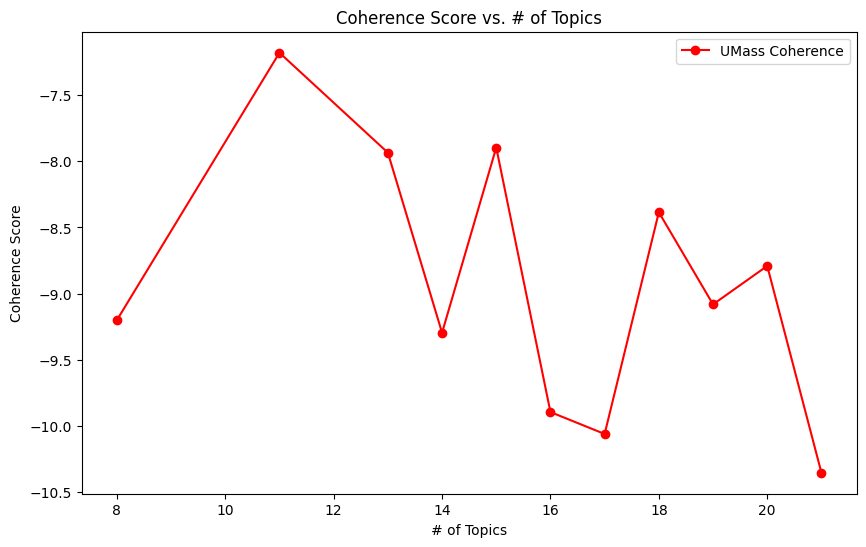

In [14]:
print("N.Topics:", n_topics)
print("Coherence score:", coherence_umass)
plt.figure(figsize=(10,6))
plt.plot(n_topics, coherence_umass, marker='o', color='red', label='UMass Coherence')
#plt.plot(n_topics, coherence_cv, marker='*', color = 'blue', label = 'CV Coherence')
plt.legend(loc='best')
plt.title('Coherence Score vs. # of Topics')
plt.xlabel('# of Topics')
plt.ylabel('Coherence Score')
plt.show()

In [6]:
#pyLDAvis (https://siqi-zhu.medium.com/ldavis-a-deep-dive-into-the-popular-topic-modeling-tool-d0c61a03e969)
pyLDAvis.enable_notebook()
model = LdaModel.load("models/lda_model_15_100")
vis = pyLDAvis.gensim_models.prepare(model, tfidf_corpus, dictionary, sort_topics=True )
pyLDAvis.display(vis)
#pyLDAvis.save_html(vis, 'lda_visualization_15_100.html') #da fare dopo la visualizzazione altrimenti non lo mostra

In [23]:
model = LdaModel.load("models/lda_model_11_100")
vis = pyLDAvis.gensim_models.prepare(model, tfidf_corpus, dictionary, sort_topics=True )
pyLDAvis.display(vis)

In [24]:
#Addestramento ulteriore per 11 topic
coherence_umass = []
coherence_cv = []
epochs = [150, 200, 250, 300, 350, 400, 500, 600]

for e in epochs:
    print(f"\n\nExecuting LDA with 11 topics and {e} epochs")
    model, umass, cv, time_s = execute_LDA(11, tfidf_corpus, dictionary, e)
    coherence_umass.append(umass)
    coherence_cv.append(cv)
    print(f"Execution time: {(time_s/60):.3f} min")
    print(f"Coherence umass: {umass:.3f} e Coherence cv: {cv:.3f}")
    print_topic(11, model)



Executing LDA with 11 topics and 150 epochs
Execution time: 16.419 min
Coherence umass: -8.444 e Coherence cv: 0.584

----- TOPIC -----
Topic1: "tuberville", "spring", "rsvp", "pact", "exposed", "schumer", "eligible", "yorkers", "till", "contact"
Topic2: "day", "today", "thank", "woman", "great", "happy", "year", "work", "community", "country"
Topic3: "larry", "elder", "adviser", "upgrade", "joy", "anybody", "suck", "profile", "trading", "surrender"
Topic4: "menendez", "newsom", "bob", "pet", "resign", "mcconnell", "mitch", "gavin", "dobbs", "shame"
Topic5: "trump", "people", "biden", "like", "want", "amp", "party", "democrat", "know", "think"
Topic6: "texas", "poll", "gun", "laura", "ingraham", "angle", "virginian", "lean", "weapon", "rating"
Topic7: "tune", "tonight", "live", "join", "watch", "listen", "hall", "town", "debate", "joining"
Topic8: "american", "job", "act", "amp", "care", "working", "family", "cost", "year", "economy"
Topic9: "trump", "vote", "gop", "election", "repub

In [31]:
#Addestramento ulteriore per 11 topic
'''
for e in [350, 400, 500, 600]:
    print(f"\n\nExecuting LDA with 11 topics and {e} epochs")
    model, umass, cv, time_s = execute_LDA(11, tfidf_corpus, dictionary, e)
    coherence_umass.append(umass)
    coherence_cv.append(cv)
    print(f"Execution time: {(time_s/60):.3f} min")
    print(f"Coherence umass: {umass:.3f} e Coherence cv: {cv:.3f}")
    print_topic(11, model)
    '''




Executing LDA with 11 topics and 350 epochs
Execution time: 43.854 min
Coherence umass: -8.373 e Coherence cv: 0.573

----- TOPIC -----
Topic1: "tuberville", "rsvp", "spring", "exposed", "schumer", "till", "highway", "rebuilding", "yorkers", "contact"
Topic2: "day", "today", "thank", "great", "happy", "woman", "year", "work", "community", "family"
Topic3: "larry", "elder", "lowest", "transit", "trading", "upgrade", "suck", "joy", "anybody", "percent"
Topic4: "menendez", "resign", "newsom", "bob", "ramaswamy", "vivek", "gavin", "mcconnell", "mitch", "pet"
Topic5: "trump", "people", "biden", "like", "want", "amp", "party", "know", "democrat", "think"
Topic6: "texas", "gun", "poll", "virginian", "lean", "rating", "writes", "prevention", "toss", "weapon"
Topic7: "tune", "tonight", "live", "join", "listen", "hall", "watch", "town", "joining", "tomorrow"
Topic8: "american", "job", "act", "amp", "working", "family", "care", "cost", "year", "economy"
Topic9: "trump", "vote", "gop", "election

[-8.444250206874493, -8.734502172365625, -7.373631049187867, -8.499699594476587, -8.373148229890369, -8.543345637122542, -7.513253868078908, -9.889141564279747] [150, 200, 250, 300, 350, 400, 500, 600]
11 topic
Coherence score: [-8.444250206874493, -8.734502172365625, -7.373631049187867, -8.499699594476587, -8.373148229890369, -8.543345637122542, -7.513253868078908, -9.889141564279747]


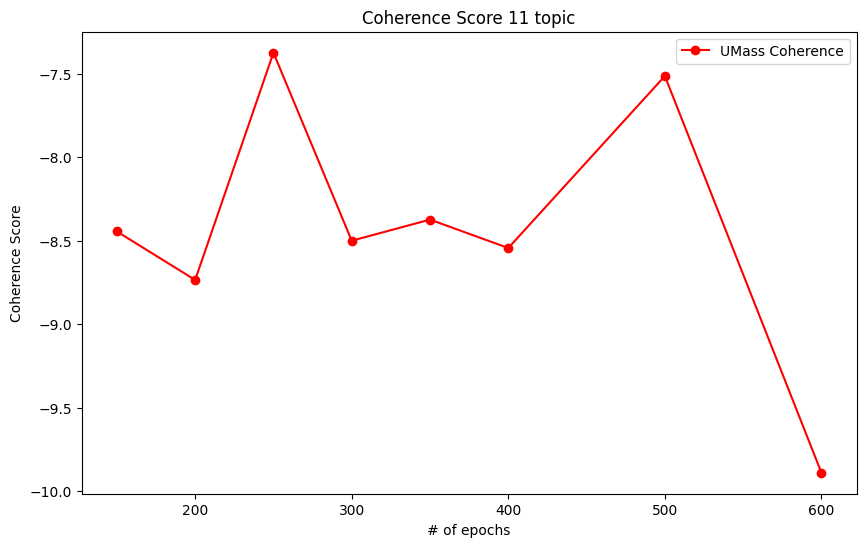

In [36]:
#Mostro i risultati per l'ulteriore addestramento
epochs = [150,200, 250, 300, 350, 400, 500, 600]
print(coherence_umass, epochs)
print("11 topic")
print("Coherence score:", coherence_umass)
plt.figure(figsize=(10,6))
plt.plot(epochs, coherence_umass, marker='o', color='red', label='UMass Coherence')
plt.legend(loc='best')
plt.title('Coherence Score 11 topic')
plt.xlabel('# of epochs')
plt.ylabel('Coherence Score')
plt.show()

In [ ]:
model = LdaModel.load("models/lda_model_11_250")
vis = pyLDAvis.gensim_models.prepare(model, tfidf_corpus, dictionary, sort_topics=True )
pyLDAvis.display(vis)

In [4]:
model = LdaModel.load("models/lda_model_11_600")
vis = pyLDAvis.gensim_models.prepare(model, tfidf_corpus, dictionary, sort_topics=True )
pyLDAvis.display(vis)

In [7]:
#Execute LDA su un numero minore di topic e 100 epoche
n_topics = []
coherence_umass = []
coherence_cv = []
epochs = 100

#Provo ad addestrare con un numero minore di topic
trial = [7,8,9,10, 12]
for i in trial:
    print(f"\n\nExecuting LDA with {i} topics and {epochs} epochs")
    n_topics.append(i)
    model, umass, cv, time_s = execute_LDA(i, tfidf_corpus, dictionary, epochs)
    coherence_umass.append(umass)
    coherence_cv.append(cv)
    print(f"Execution time: {(time_s/60):.3f} min")
    print(f"Coherence umass: {umass:.3f} e Coherence cv: {cv:.3f}")
    print_topic(i, model)



Executing LDA with 7 topics and 100 epochs


Execution time: 17.274 min
Coherence umass: -5.201 e Coherence cv: 0.553

----- TOPIC -----
Topic1: "biden", "border", "joe", "hunter", "house", "illegal", "crisis", "impeachment", "president", "mccarthy"
Topic2: "day", "today", "great", "thank", "join", "happy", "tune", "year", "honor", "tonight"
Topic3: "menendez", "laura", "bob", "ingraham", "angle", "resign", "senator", "older", "african", "tonight"
Topic4: "abortion", "woman", "right", "court", "freedom", "reproductive", "decision", "supreme", "ban", "larry"
Topic5: "ukraine", "war", "biden", "trump", "amp", "china", "military", "people", "israel", "state"
Topic6: "american", "job", "act", "working", "family", "worker", "amp", "work", "care", "year"
Topic7: "trump", "election", "vote", "republican", "debate", "candidate", "gop", "poll", "voter", "democrat"


Executing LDA with 8 topics and 100 epochs
Execution time: 11.794 min
Coherence umass: -7.737 e Coherence cv: 0.536

----- TOPIC -----
Topic1: "border", "biden", "speaker", "m

In [12]:
model = LdaModel.load("models/lda_model_7_100")
vis = pyLDAvis.gensim_models.prepare(model, tfidf_corpus, dictionary, sort_topics=True )
pyLDAvis.display(vis)
#pyLDAvis.save_html(vis, 'lda_visualization_7_100.html')

In [23]:
#Executing 7 topics with different epochs
coherence_7_umass = []
topic = 7
epochs = [1, 5, 10, 20, 30 ,40 ,50 ,60 ,70 ,80 ,90, 100, 120]
for e in epochs:
    print(f"\n\nExecuting LDA with {topic} topics and {e} epochs")
    model, umass, cv, time_s = execute_LDA(7, tfidf_corpus, dictionary, e)
    coherence_7_umass.append(umass)
    print(f"Execution time: {(time_s/60):.3f} min")
    print(f"Coherence umass: {umass:.3f} e Coherence cv: {cv:.3f}")
    print_topic(topic, model)



Executing LDA with 7 topics and 1 epochs


Execution time: 0.320 min
Coherence umass: -2.893 e Coherence cv: 0.508

----- TOPIC -----
Topic1: "job", "american", "biden", "care", "year", "family", "president", "working", "need", "million"
Topic2: "trump", "people", "biden", "american", "right", "party", "president", "america", "republican", "state"
Topic3: "biden", "republican", "trump", "elder", "american", "state", "year", "right", "people", "house"
Topic4: "trump", "biden", "president", "republican", "donald", "democrat", "gop", "time", "like", "debate"
Topic5: "biden", "american", "vote", "people", "today", "border", "law", "state", "house", "republican"
Topic6: "day", "election", "today", "state", "happy", "thank", "biden", "great", "student", "time"
Topic7: "american", "right", "biden", "woman", "today", "president", "year", "trump", "fight", "climate"


Executing LDA with 7 topics and 5 epochs
Execution time: 1.026 min
Coherence umass: -5.136 e Coherence cv: 0.557

----- TOPIC -----
Topic1: "american", "job", "working", "

[-2.892965800456395, -5.135764911693228, -5.697392022925255, -5.933761709583623, -5.781216430575065, -5.86324241498562, -5.8723413131867295, -5.868806736030466, -6.269335954191779, -5.947404544522486, -5.78631513946751, -5.964363233368454, -5.74044170309711] [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120]
Massimo valore ottenuto:  -2.892965800456395
7 topic
Coherence score: [-5.2013079808763445, -7.736869013453537, -9.574157608780794, -7.267087164449914, -9.109872493123861]


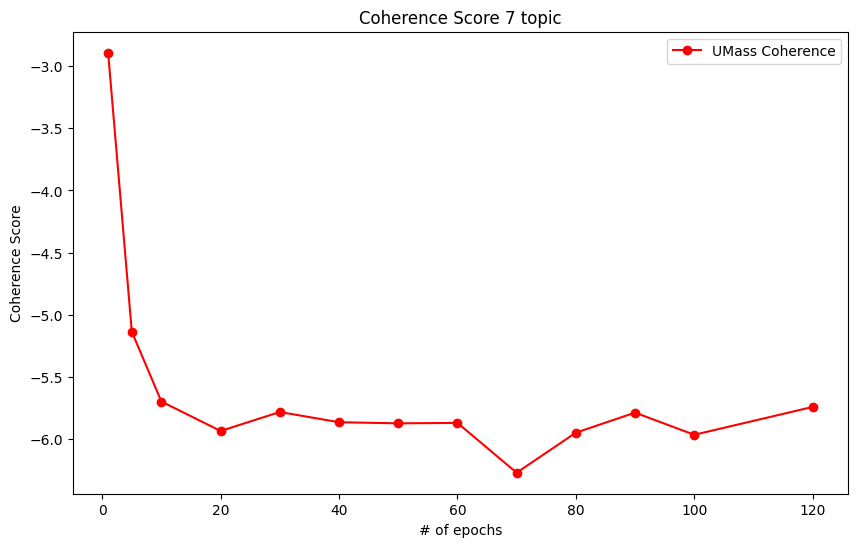

In [25]:
#Plot the coherence for the 7 topics
print(coherence_7_umass, epochs)
max_score = max(coherence_7_umass)
print("Massimo valore ottenuto: ", max_score)
print("7 topic")
print("Coherence score:", coherence_umass)
plt.figure(figsize=(10,6))
plt.plot(epochs, coherence_7_umass, marker='o', color='red', label='UMass Coherence')
plt.legend(loc='best')
plt.title('Coherence Score 7 topic')
plt.xlabel('# of epochs')
plt.ylabel('Coherence Score')
plt.show()


In [26]:
#Executing 8 topics with different epochs
coherence_8_umass = []
coherence_8_cv = []
topic = 8
epochs = [1, 5, 10, 20, 30 ,40 ,50 ,60 ,70 ,80 ,90, 100, 110]
for e in epochs:
    print(f"\n\nExecuting LDA with {topic} topics and {e} epochs")
    model, umass, cv, time_s = execute_LDA(topic, tfidf_corpus, dictionary, e)
    coherence_8_umass.append(umass)
    coherence_8_cv.append(cv)
    print(f"Execution time: {(time_s/60):.3f} min")
    print(f"Coherence umass: {umass:.3f} e Coherence cv: {cv:.3f}")
    print_topic(topic, model)



Executing LDA with 8 topics and 1 epochs
Execution time: 0.220 min
Coherence umass: -3.084 e Coherence cv: 0.494

----- TOPIC -----
Topic1: "care", "health", "job", "act", "american", "family", "biden", "year", "working", "republican"
Topic2: "trump", "people", "biden", "gun", "american", "republican", "party", "president", "time", "violence"
Topic3: "elder", "right", "biden", "trump", "court", "time", "voting", "people", "mccarthy", "american"
Topic4: "trump", "biden", "president", "donald", "republican", "election", "debate", "time", "people", "joe"
Topic5: "today", "border", "biden", "year", "day", "american", "happy", "state", "family", "people"
Topic6: "colorado", "election", "biden", "state", "trump", "day", "people", "vote", "president", "thank"
Topic7: "american", "woman", "president", "trump", "right", "biden", "people", "state", "today", "house"
Topic8: "american", "america", "biden", "year", "worker", "job", "family", "infrastructure", "president", "law"


Executing LDA wi

8 topic
Coherence score: [-3.0835910761166008, -4.654065951448132, -4.859301065526287, -5.161294170149704, -4.991111420748183, -4.894645024710876, -4.96853553548641, -5.279782132758272, -4.926276976599433, -4.977975137594242, -4.870220013801567, -4.9654678401137335, -5.35875671909673]
coherence cv:  [0.4939551816196816, 0.5439691091768071, 0.5586316125456219, 0.5602749671471333, 0.5776659224230293, 0.5731926042307702, 0.5861933098014779, 0.5801699656293717, 0.5820261019077786, 0.5777871108374146, 0.574786516601792, 0.5889963797301465, 0.566427724667778]
Massimo valore umass:  -3.0835910761166008
max valore cv:  0.5889963797301465


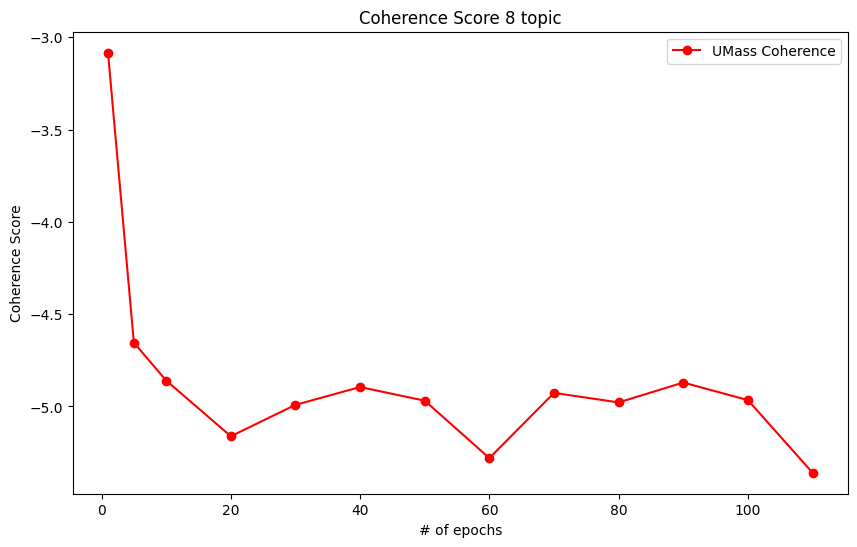

In [27]:
#Plot the coherence for the 8 topics
print("8 topic")
print("Coherence score:", coherence_8_umass)
print("coherence cv: ", coherence_8_cv)

print("Massimo valore umass: ", max(coherence_8_umass))
print("max valore cv: ", max(coherence_8_cv))
plt.figure(figsize=(10,6))
plt.plot(epochs, coherence_8_umass, marker='o', color='red', label='UMass Coherence')
plt.legend(loc='best')
plt.title('Coherence Score 8 topic')
plt.xlabel('# of epochs')
plt.ylabel('Coherence Score')
plt.show()


In [28]:
#Executing 9 topics with different epochs
coherence_9_umass = []
coherence_9_cv = []
topic = 9
epochs = [1, 5, 10, 20, 30 ,40 ,50 ,60 ,70 ,80 ,90, 100, 110]
for e in epochs:
    print(f"\n\nExecuting LDA with {topic} topics and {e} epochs")
    model, umass, cv, time_s = execute_LDA(topic, tfidf_corpus, dictionary, e)
    coherence_9_umass.append(umass)
    coherence_9_cv.append(cv)
    print(f"Execution time: {(time_s/60):.3f} min")
    print(f"Coherence umass: {umass:.3f} e Coherence cv: {cv:.3f}")
    print_topic(topic, model)



Executing LDA with 9 topics and 1 epochs
Execution time: 0.225 min
Coherence umass: -3.225 e Coherence cv: 0.492

----- TOPIC -----
Topic1: "biden", "border", "job", "gun", "american", "need", "president", "house", "year", "republican"
Topic2: "trump", "biden", "president", "republican", "people", "state", "house", "party", "time", "american"
Topic3: "elder", "cost", "american", "drug", "medicare", "senior", "biden", "larry", "republican", "insulin"
Topic4: "trump", "biden", "republican", "president", "democrat", "time", "want", "like", "need", "state"
Topic5: "american", "biden", "people", "state", "today", "right", "year", "worker", "day", "woman"
Topic6: "great", "american", "day", "biden", "today", "year", "school", "state", "child", "family"
Topic7: "american", "right", "today", "woman", "year", "president", "act", "work", "fight", "people"
Topic8: "veteran", "biden", "america", "infrastructure", "state", "year", "care", "benefit", "president", "american"
Topic9: "vote", "trump"

9 topic
Coherence score: [-3.225218943760299, -3.519209014034802, -4.1977669541785785, -4.035080906590508, -4.96761936003067, -5.160465339310133, -4.984377845969611, -5.5249887929530725, -4.499409276066938, -5.829307386372111, -6.286388054339093, -5.771997030468208, -6.049683537191993]
coherence cv:  [0.49204043720686463, 0.5697479856569794, 0.5601192110212679, 0.5634894174825948, 0.5608176014626637, 0.5554688944458719, 0.5613863857102457, 0.5559136834108128, 0.552869257542929, 0.5446054688297599, 0.5633305619050487, 0.5432131342252194, 0.5471206467166124]
Massimo valore umass:  -3.225218943760299
max valore cv:  0.5697479856569794


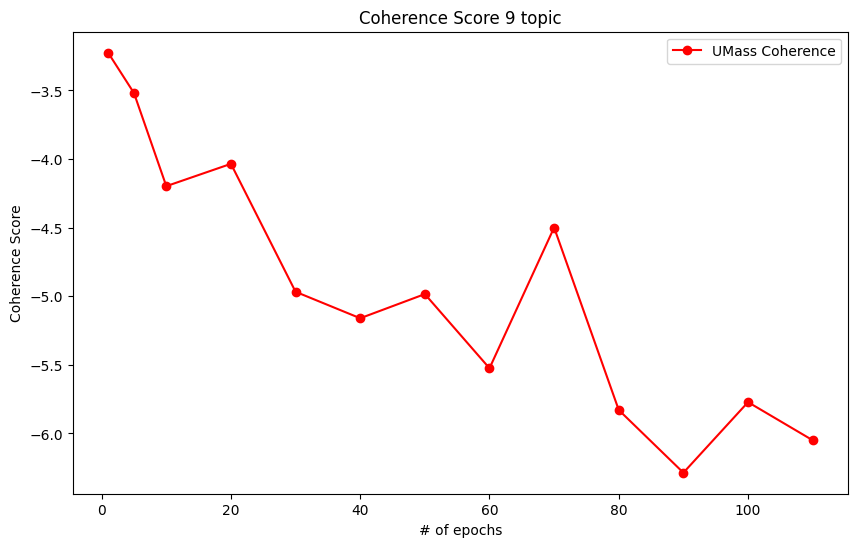

In [29]:
#Plot the coherence for the 9 topics
print("9 topic")
print("Coherence score:", coherence_9_umass)
print("coherence cv: ", coherence_9_cv)

print("Massimo valore umass: ", max(coherence_9_umass))
print("max valore cv: ", max(coherence_9_cv))
plt.figure(figsize=(10,6))
plt.plot(epochs, coherence_9_umass, marker='o', color='red', label='UMass Coherence')
plt.legend(loc='best')
plt.title('Coherence Score 9 topic')
plt.xlabel('# of epochs')
plt.ylabel('Coherence Score')
plt.show()


In [30]:
#Executing 10 topics with different epochs
coherence_10_umass = []
coherence_10_cv = []
topic = 10
epochs = [1, 5, 10, 20, 30 ,40 ,50 ,60 ,70 ,80 ,90, 100, 110]
for e in epochs:
    print(f"\n\nExecuting LDA with {topic} topics and {e} epochs")
    model, umass, cv, time_s = execute_LDA(topic, tfidf_corpus, dictionary, e)
    coherence_10_umass.append(umass)
    coherence_10_cv.append(cv)
    print(f"Execution time: {(time_s/60):.3f} min")
    print(f"Coherence umass: {umass:.3f} e Coherence cv: {cv:.3f}")
    print_topic(topic, model)



Executing LDA with 10 topics and 1 epochs
Execution time: 0.229 min
Coherence umass: -3.166 e Coherence cv: 0.497

----- TOPIC -----
Topic1: "biden", "american", "great", "president", "week", "today", "community", "state", "need", "live"
Topic2: "biden", "trump", "writes", "republican", "democrat", "people", "american", "president", "house", "party"
Topic3: "trump", "biden", "right", "republican", "day", "court", "american", "people", "like", "state"
Topic4: "trump", "biden", "president", "donald", "republican", "election", "debate", "time", "joe", "party"
Topic5: "biden", "border", "day", "happy", "people", "today", "american", "state", "trump", "year"
Topic6: "elder", "biden", "community", "state", "election", "america", "today", "american", "like", "president"
Topic7: "american", "fight", "right", "work", "today", "woman", "year", "job", "people", "working"
Topic8: "american", "cost", "job", "act", "family", "care", "year", "republican", "tax", "million"
Topic9: "vote", "right", "

10 topic
Coherence score: [-3.166284859785047, -5.427913328074739, -6.732767783021416, -7.1599826865318565, -7.190588780827406, -7.160413276383072, -6.958485608743649, -7.169308580080451, -8.442866119719227, -7.28791111632066, -7.386194992982515, -7.3431926583927005, -7.077098473865499]
coherence cv:  [0.49696767003564846, 0.5280321007526466, 0.5478711695808526, 0.5553714694219185, 0.5453423413072327, 0.573082672344281, 0.5471322610700472, 0.5518329852347763, 0.5476795251939135, 0.5747586813655519, 0.5567748334594613, 0.5642868235943432, 0.5560133175839059]
Massimo valore umass:  -3.166284859785047
max valore cv:  0.5747586813655519


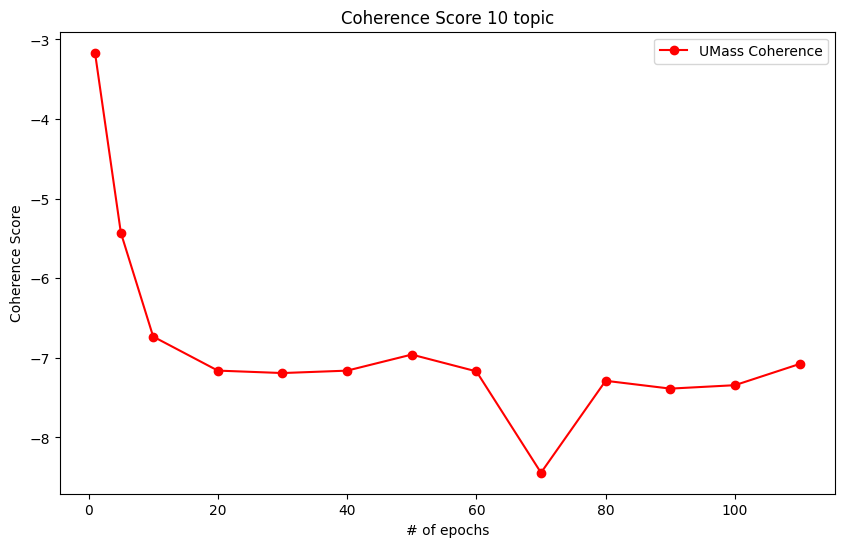

In [31]:
#Plot the coherence 
print("10 topic")
print("Coherence score:", coherence_10_umass)
print("coherence cv: ", coherence_10_cv)

print("Massimo valore umass: ", max(coherence_10_umass))
print("max valore cv: ", max(coherence_10_cv))
plt.figure(figsize=(10,6))
plt.plot(epochs, coherence_10_umass, marker='o', color='red', label='UMass Coherence')
plt.legend(loc='best')
plt.title('Coherence Score 10 topic')
plt.xlabel('# of epochs')
plt.ylabel('Coherence Score')
plt.show()


In [32]:
#Executing 11 topics with different epochs
coherence_11_umass = []
coherence_11_cv = []
topic = 11
epochs = [1, 5, 10, 20, 30 ,40 ,50 ,60 ,70 ,80 ,90, 100, 110]
for e in epochs:
    print(f"\n\nExecuting LDA with {topic} topics and {e} epochs")
    model, umass, cv, time_s = execute_LDA(topic, tfidf_corpus, dictionary, e)
    coherence_11_umass.append(umass)
    coherence_11_cv.append(cv)
    print(f"Execution time: {(time_s/60):.3f} min")
    print(f"Coherence umass: {umass:.3f} e Coherence cv: {cv:.3f}")
    print_topic(topic, model)



Executing LDA with 11 topics and 1 epochs
Execution time: 0.216 min
Coherence umass: -3.365 e Coherence cv: 0.475

----- TOPIC -----
Topic1: "biden", "american", "family", "town", "join", "hall", "elder", "drug", "today", "need"
Topic2: "trump", "gun", "biden", "president", "people", "american", "israel", "need", "violence", "republican"
Topic3: "right", "biden", "mccarthy", "republican", "vote", "voting", "people", "american", "kevin", "trump"
Topic4: "trump", "biden", "republican", "president", "democrat", "donald", "jersey", "time", "american", "debt"
Topic5: "american", "biden", "year", "today", "cost", "insulin", "border", "state", "act", "people"
Topic6: "american", "job", "year", "president", "people", "state", "biden", "today", "family", "work"
Topic7: "job", "energy", "american", "infrastructure", "community", "act", "investment", "work", "climate", "year"
Topic8: "biden", "president", "trump", "america", "year", "time", "state", "american", "assault", "warren"
Topic9: "bide

11 topic
Coherence score: [-3.3651972695562886, -6.306272586604078, -6.917539915401787, -7.262947243513313, -7.17605987727408, -8.529982215188527, -7.461431172501269, -7.632681380542377, -8.076999477048668, -7.968371704385629, -8.388497780408214, -8.418197159196668, -8.634229160379872]
coherence cv:  [0.47450172690310405, 0.542933840028632, 0.5606824290351388, 0.5677030460521602, 0.5620257679685735, 0.5865732686388315, 0.5787781464377544, 0.5754300528837649, 0.5693598532359698, 0.5644643881057706, 0.5554308330980727, 0.5786708914683952, 0.5729273847556419]
Massimo valore umass:  -3.3651972695562886
max valore cv:  0.5865732686388315


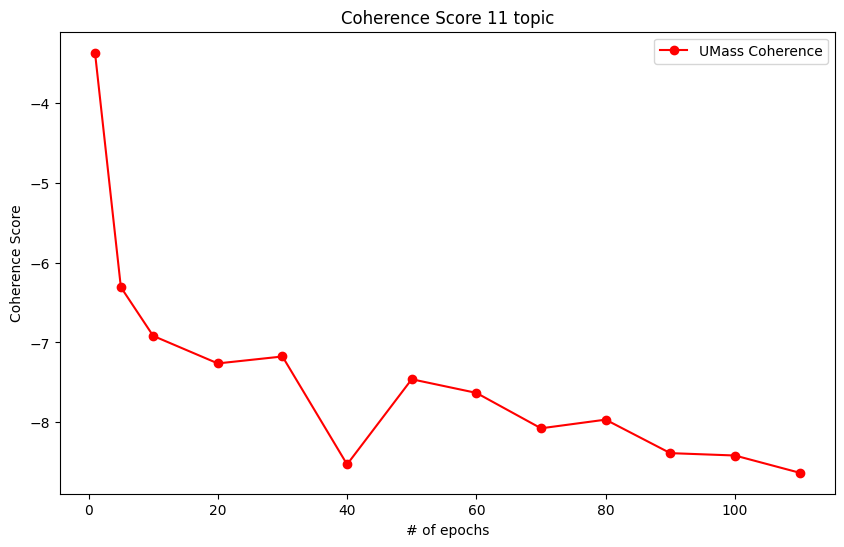

In [33]:
#Plot the coherence 
print("11 topic")
print("Coherence score:", coherence_11_umass)
print("coherence cv: ", coherence_11_cv)

print("Massimo valore umass: ", max(coherence_11_umass))
print("max valore cv: ", max(coherence_11_cv))
plt.figure(figsize=(10,6))
plt.plot(epochs, coherence_11_umass, marker='o', color='red', label='UMass Coherence')
plt.legend(loc='best')
plt.title('Coherence Score 11 topic')
plt.xlabel('# of epochs')
plt.ylabel('Coherence Score')
plt.show()


In [34]:
#Executing 15 topics with different epochs
coherence_15_umass = []
coherence_15_cv = []
topic = 15
epochs = [1, 5, 10, 20, 30 ,40 ,50 ,60 ,70 ,80 ,90, 100, 110]
for e in epochs:
    print(f"\n\nExecuting LDA with {topic} topics and {e} epochs")
    model, umass, cv, time_s = execute_LDA(topic, tfidf_corpus, dictionary, e)
    coherence_15_umass.append(umass)
    coherence_15_cv.append(cv)
    print(f"Execution time: {(time_s/60):.3f} min")
    print(f"Coherence umass: {umass:.3f} e Coherence cv: {cv:.3f}")
    print_topic(topic, model)



Executing LDA with 15 topics and 1 epochs
Execution time: 0.411 min
Coherence umass: -3.470 e Coherence cv: 0.480

----- TOPIC -----
Topic1: "biden", "border", "trump", "president", "american", "rsvp", "state", "joe", "need", "like"
Topic2: "trump", "president", "biden", "people", "american", "republican", "ukraine", "state", "america", "stand"
Topic3: "trump", "right", "biden", "election", "people", "vote", "state", "marco", "voting", "today"
Topic4: "trump", "biden", "president", "republican", "debt", "time", "american", "democrat", "house", "worker"
Topic5: "biden", "state", "american", "today", "infrastructure", "climate", "border", "people", "energy", "president"
Topic6: "writes", "biden", "american", "president", "student", "job", "community", "america", "people", "great"
Topic7: "american", "today", "job", "michigander", "vote", "day", "biden", "year", "woman", "people"
Topic8: "gun", "care", "act", "child", "american", "veteran", "year", "family", "america", "benefit"
Topic9:

15 topic
Coherence score: [-3.4704472446331396, -6.547665804413929, -7.564835140981712, -8.373488248893803, -9.176637353880638, -9.575133838152261, -9.08730496044915, -9.83641354356248, -10.03636040827181, -9.041968091838323, -8.878014155879589, -10.03168433960103, -8.746033953870894]
coherence cv:  [0.4798215134267718, 0.5210209722253445, 0.5256568211527562, 0.5391944330218731, 0.5480279500774422, 0.5687798323468698, 0.5693526840160944, 0.5794090471332081, 0.5858849508960527, 0.5785804187570437, 0.5740762019930615, 0.5864102671798874, 0.5714203178518316]
Massimo valore umass:  -3.4704472446331396
max valore cv:  0.5864102671798874


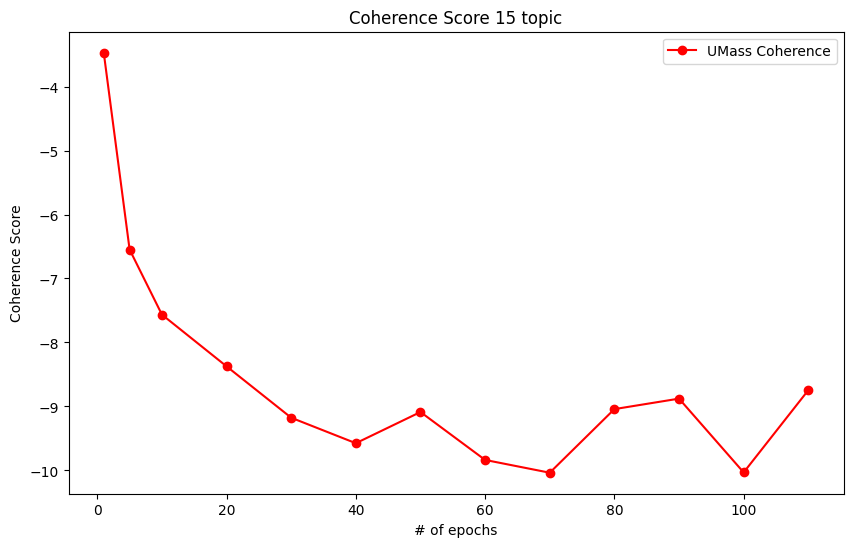

In [35]:
#Plot the coherence 
print("15 topic")
print("Coherence score:", coherence_15_umass)
print("coherence cv: ", coherence_15_cv)

print("Massimo valore umass: ", max(coherence_15_umass))
print("max valore cv: ", max(coherence_15_cv))
plt.figure(figsize=(10,6))
plt.plot(epochs, coherence_15_umass, marker='o', color='red', label='UMass Coherence')
plt.legend(loc='best')
plt.title('Coherence Score 15 topic')
plt.xlabel('# of epochs')
plt.ylabel('Coherence Score')
plt.show()


In [36]:
#Executing 19 topics with different epochs
coherence_19_umass = []
coherence_19_cv = []
topic = 19
epochs = [1, 5, 10, 20, 30 ,40 ,50 ,60 ,70 ,80 ,90, 100, 110]
for e in epochs:
    print(f"\n\nExecuting LDA with {topic} topics and {e} epochs")
    model, umass, cv, time_s = execute_LDA(topic, tfidf_corpus, dictionary, e)
    coherence_19_umass.append(umass)
    coherence_19_cv.append(cv)
    print(f"Execution time: {(time_s/60):.3f} min")
    print(f"Coherence umass: {umass:.3f} e Coherence cv: {cv:.3f}")
    print_topic(topic, model)



Executing LDA with 19 topics and 1 epochs
Execution time: 0.258 min
Coherence umass: -4.076 e Coherence cv: 0.435

----- TOPIC -----
Topic1: "job", "biden", "economy", "american", "created", "year", "president", "million", "people", "work"
Topic2: "thank", "people", "trump", "state", "time", "year", "today", "american", "community", "minnesota"
Topic3: "mccarthy", "kevin", "biden", "gun", "colorado", "american", "house", "older", "people", "year"
Topic4: "trump", "biden", "republican", "toss", "run", "president", "charge", "lean", "democrat", "miami"
Topic5: "american", "biden", "border", "tuberville", "state", "people", "child", "president", "democrat", "time"
Topic6: "insulin", "cost", "senior", "president", "month", "biden", "american", "year", "today", "massachusetts"
Topic7: "right", "gun", "woman", "fight", "today", "community", "violence", "state", "act", "american"
Topic8: "infrastructure", "internet", "speed", "debt", "day", "president", "biden", "republican", "house", "amer

19 topic
Coherence score: [-4.075680493199955, -6.989001948053544, -7.7588145643920425, -8.639618195534707, -9.098349197235162, -8.757348935175811, -8.88066383016376, -9.16349500551578, -9.033521741363572, -8.91061040859163, -9.049559234165832, -8.85512444500582, -8.98700020215609]
coherence cv:  [0.43462452297941306, 0.5309199330326194, 0.5627105051321657, 0.5798253971120838, 0.5524416953922551, 0.5742653190440015, 0.5845331013670154, 0.5752412195473516, 0.5668528883400805, 0.5630668646458536, 0.5715040124440923, 0.5676840371854994, 0.5799557043770388]
Massimo valore umass:  -4.075680493199955
max valore cv:  0.5845331013670154


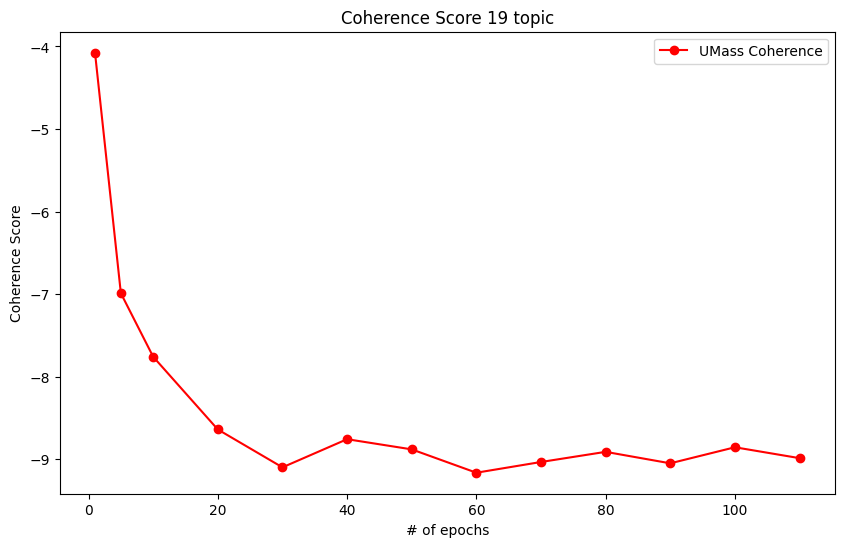

In [37]:
#Plot the coherence 
print("19 topic")
print("Coherence score:", coherence_19_umass)
print("coherence cv: ", coherence_19_cv)

print("Massimo valore umass: ", max(coherence_19_umass))
print("max valore cv: ", max(coherence_19_cv))
plt.figure(figsize=(10,6))
plt.plot(epochs, coherence_19_umass, marker='o', color='red', label='UMass Coherence')
plt.legend(loc='best')
plt.title('Coherence Score 19 topic')
plt.xlabel('# of epochs')
plt.ylabel('Coherence Score')
plt.show()


In [82]:
model = LdaModel.load("models/lda_model_7_1")
vis = pyLDAvis.gensim_models.prepare(model, tfidf_corpus, dictionary, sort_topics=True )
pyLDAvis.display(vis)
#pyLDAvis.save_html(vis, 'lda_visualization_7_1_umass_2893.html')

In [16]:
model = LdaModel.load("models/lda_model_7_40")
vis = pyLDAvis.gensim_models.prepare(model, tfidf_corpus, dictionary, sort_topics=True )
pyLDAvis.display(vis)
#pyLDAvis.save_html(vis, 'lda_visualization_7_40_cv_0586.html')

In [8]:
model = LdaModel.load("models/lda_model_8_1")
vis = pyLDAvis.gensim_models.prepare(model, tfidf_corpus, dictionary, sort_topics=True )
pyLDAvis.display(vis)
#pyLDAvis.save_html(vis, 'lda_visualization_7_100.html')

In [17]:
model = LdaModel.load("models/lda_model_8_100")
vis = pyLDAvis.gensim_models.prepare(model, tfidf_corpus, dictionary, sort_topics=True )
pyLDAvis.display(vis)
#pyLDAvis.save_html(vis, 'lda_visualization_8_100_cv_0589.html')

In [10]:
model = LdaModel.load("models/lda_model_11_1")
vis = pyLDAvis.gensim_models.prepare(model, tfidf_corpus, dictionary, sort_topics=True )
pyLDAvis.display(vis)
#pyLDAvis.save_html(vis, 'lda_visualization_7_100.html')

In [78]:
model = LdaModel.load("models/lda_model_11_40")
vis = pyLDAvis.gensim_models.prepare(model, tfidf_corpus, dictionary, sort_topics=True )
pyLDAvis.display(vis)
#pyLDAvis.save_html(vis, 'lda_visualization_7_100.html')

In [109]:
#Training 7 topic con varie epoche 
coherence_umass = []
coherence_cv = []
coherence_uci = []
coherence_npmi = []

topic = 7
epochs = [1, 5, 10, 20, 30 ,40 ,50 ,60 ,70 ,80 ,90, 100, 110, 150, 200, 250, 300, 350]
for e in epochs:
    print(f"\n\nExecuting LDA with {topic} topics and {e} epochs")
    model, umass, cv, time_s, uci, npmi = execute_LDA(topic, tfidf_corpus, dictionary, e, name = "v2")
    coherence_umass.append(umass)
    coherence_cv.append(cv)
    coherence_uci.append(uci)
    coherence_npmi.append(npmi)
    print(f"Execution time: {(time_s/60):.3f} min")
    print(f"Coherence umass: {umass:.3f} e Coherence cv: {cv:.3f} e Coherence uci: {uci:.3f} e Coherence npmi: {npmi:.3f}")
    print_topic(topic, model)




Executing LDA with 7 topics and 1 epochs
Execution time: 0.280 min
Coherence umass: -2.975 e Coherence cv: 0.505 e Coherence uci: -0.034 e Coherence npmi: 0.004

----- TOPIC -----
Topic1: "job", "american", "care", "biden", "year", "family", "million", "president", "health", "cost"
Topic2: "trump", "people", "american", "right", "biden", "party", "president", "america", "republican", "state"
Topic3: "biden", "republican", "american", "trump", "state", "year", "right", "need", "time", "day"
Topic4: "trump", "biden", "republican", "president", "donald", "election", "democrat", "candidate", "presidential", "debate"
Topic5: "biden", "american", "state", "vote", "law", "today", "people", "need", "border", "year"
Topic6: "day", "today", "happy", "election", "student", "state", "thank", "colorado", "great", "community"
Topic7: "american", "right", "woman", "biden", "president", "fight", "today", "year", "trump", "work"


Executing LDA with 7 topics and 5 epochs
Execution time: 0.818 min
Coh

7 topic
Epochs:  [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 150, 200, 250, 300, 350]
Coherence score: [-2.975006976168353, -5.014509664162822, -5.582799794039701, -5.913176812850057, -5.712815560947968, -5.889808318039735, -5.852536545382177, -5.778617855308459, -6.020284002229665, -5.951541535586623, -5.951577934181974, -5.913241774748194, -5.884856029048883, -6.888237542590028, -6.2101004136583295, -5.919690865295414, -5.974742167320885, -5.936436694463831] Max value:  -2.975006976168353 all epoca: 1
coherence cv:  [0.5054771540516816, 0.5567949767737832, 0.5581743149812757, 0.5789011676351594, 0.5739855184181784, 0.5796616302281443, 0.5711880164374088, 0.5765225627183839, 0.582838608491497, 0.5782632872879935, 0.5727424012581467, 0.5746669794865318, 0.5703231024769606, 0.565553492115476, 0.557299418407688, 0.5801031856619154, 0.5718961410217803, 0.5751292978478674] Max value:  0.582838608491497 all epoca: 70
coherence uci:  [-0.03365231616189778, -1.2831388438605131, -1.61

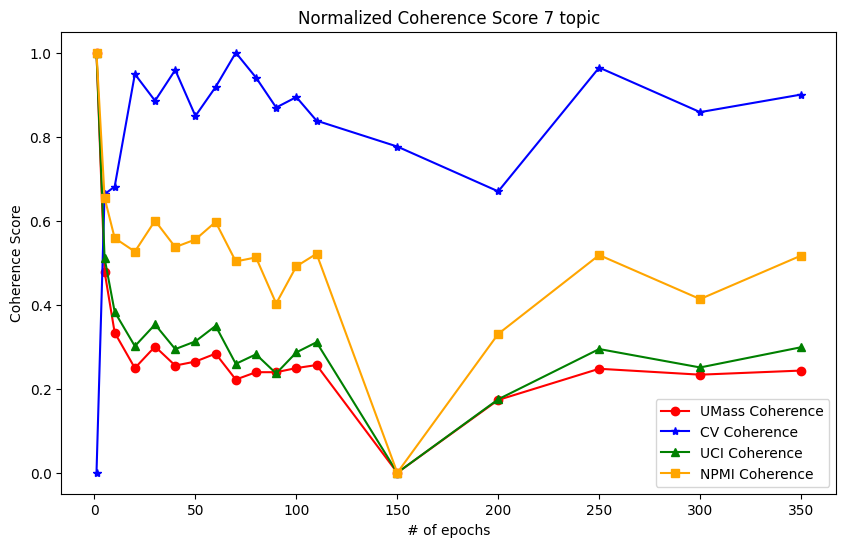

In [110]:
pretty_print(topic, epochs, coherence_umass, coherence_cv, coherence_uci, coherence_npmi)

In [111]:
#Training 8 topic con varie epoche 
coherence_umass = []
coherence_cv = []
coherence_uci = []
coherence_npmi = []

topic = 8
epochs = [1, 5, 10, 20, 30 ,40 ,50 ,60 ,70 ,80 ,90, 100, 110, 150, 200, 250, 300, 350]
for e in epochs:
    print(f"\n\nExecuting LDA with {topic} topics and {e} epochs")
    model, umass, cv, time_s, uci, npmi = execute_LDA(topic, tfidf_corpus, dictionary, e, name = "v2")
    coherence_umass.append(umass)
    coherence_cv.append(cv)
    coherence_uci.append(uci)
    coherence_npmi.append(npmi)
    print(f"Execution time: {(time_s/60):.3f} min")
    print(f"Coherence umass: {umass:.3f} e Coherence cv: {cv:.3f} e Coherence uci: {uci:.3f} e Coherence npmi: {npmi:.3f}")
    print_topic(topic, model)




Executing LDA with 8 topics and 1 epochs
Execution time: 0.313 min
Coherence umass: -3.059 e Coherence cv: 0.495 e Coherence uci: -0.119 e Coherence npmi: 0.002

----- TOPIC -----
Topic1: "care", "health", "job", "american", "biden", "act", "family", "year", "working", "republican"
Topic2: "trump", "people", "biden", "party", "gun", "american", "time", "president", "republican", "violence"
Topic3: "elder", "right", "biden", "trump", "court", "voting", "people", "american", "time", "mccarthy"
Topic4: "trump", "biden", "president", "republican", "donald", "time", "people", "election", "larry", "party"
Topic5: "border", "year", "biden", "american", "today", "day", "happy", "state", "family", "people"
Topic6: "election", "biden", "vote", "trump", "people", "state", "day", "colorado", "american", "thank"
Topic7: "president", "woman", "american", "right", "trump", "people", "biden", "state", "today", "house"
Topic8: "american", "america", "job", "biden", "year", "worker", "family", "presid

8 topic
Epochs:  [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 150, 200, 250, 300, 350]
Coherence score: [-3.059355200485608, -4.8069012209922795, -5.599650853265535, -5.315323789620562, -4.882226858126806, -4.941518755320804, -5.167030138140536, -4.976902852621516, -4.975882332979592, -5.10999645596198, -4.971250482458301, -5.4432580525368905, -4.976137048606585, -4.885549890595708, -4.870360467511678, -4.966706241414857, -4.973600476135683, -4.9203523203050805] Max value:  -3.059355200485608 all epoca: 1
coherence cv:  [0.49484609104008087, 0.5641033299068439, 0.5594883455574049, 0.5853666107906059, 0.5770016356234817, 0.5767799251112358, 0.565336830995641, 0.5740756007231071, 0.6004658424540181, 0.5770424285059097, 0.5797296490901651, 0.5688395819140815, 0.5789786703392319, 0.5737815696134289, 0.5766179772424429, 0.5830326390855968, 0.564899902986652, 0.5676716310366611] Max value:  0.6004658424540181 all epoca: 70
coherence uci:  [-0.11898044439539815, -0.9987668215486152, -

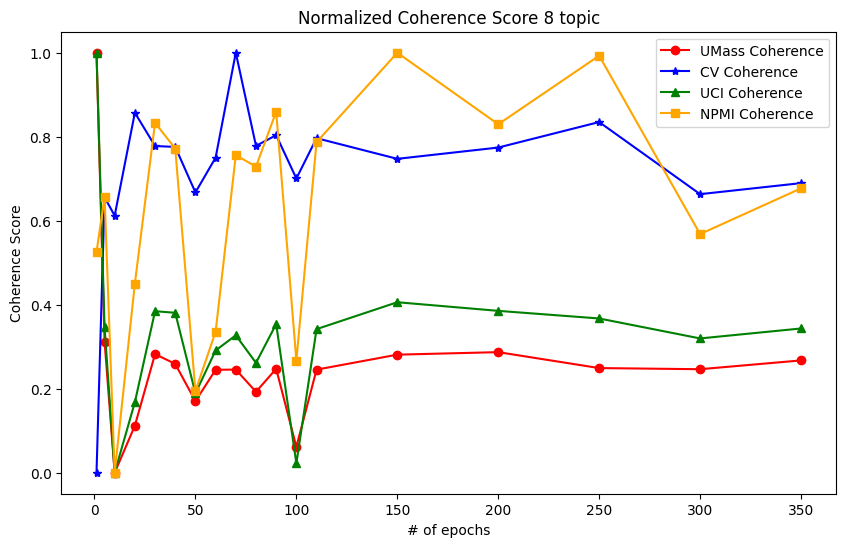

In [112]:
pretty_print(topic, epochs, coherence_umass, coherence_cv, coherence_uci, coherence_npmi)

In [12]:
#Training 9 topic con varie epoche 
coherence_umass = []
coherence_cv = []
coherence_uci = []
coherence_npmi = []

topic = 9
epochs = [1, 5, 10, 20, 30 ,40 ,50 ,60 ,70 ,80 ,90, 100, 110, 150, 200, 250, 300, 350]
for e in epochs:
    print(f"\n\nExecuting LDA with {topic} topics and {e} epochs")
    model, umass, cv, time_s, uci, npmi = execute_LDA(topic, tfidf_corpus, dictionary, e, name = "v2")
    coherence_umass.append(umass)
    coherence_cv.append(cv)
    coherence_uci.append(uci)
    coherence_npmi.append(npmi)
    print(f"Execution time: {(time_s/60):.3f} min")
    print(f"Coherence umass: {umass:.3f} e Coherence cv: {cv:.3f} e Coherence uci: {uci:.3f} e Coherence npmi: {npmi:.3f}")
    print_topic(topic, model)




Executing LDA with 9 topics and 1 epochs


ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/lucia/.local/lib/p

Execution time: 0.330 min
Coherence umass: -3.177 e Coherence cv: 0.499 e Coherence uci: -0.158 e Coherence npmi: 0.005

----- TOPIC -----
Topic1: "biden", "border", "gun", "job", "american", "need", "president", "year", "house", "crisis"
Topic2: "trump", "biden", "president", "republican", "people", "state", "house", "party", "time", "american"
Topic3: "elder", "cost", "american", "senior", "medicare", "drug", "biden", "larry", "republican", "insulin"
Topic4: "trump", "biden", "republican", "president", "democrat", "time", "want", "donald", "like", "state"
Topic5: "american", "biden", "people", "state", "today", "right", "year", "trump", "woman", "day"
Topic6: "great", "american", "day", "biden", "year", "today", "state", "school", "child", "president"
Topic7: "right", "american", "woman", "today", "year", "president", "fight", "work", "act", "people"
Topic8: "biden", "veteran", "care", "infrastructure", "america", "state", "year", "benefit", "act", "president"
Topic9: "vote", "trump"

ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/lucia/.local/lib/p

Execution time: 0.806 min
Coherence umass: -3.829 e Coherence cv: 0.543 e Coherence uci: -0.358 e Coherence npmi: 0.033

----- TOPIC -----
Topic1: "border", "biden", "gun", "tune", "american", "crisis", "president", "job", "bidenomics", "violence"
Topic2: "ukraine", "house", "war", "trump", "republican", "biden", "speaker", "party", "people", "democrat"
Topic3: "cost", "drug", "prescription", "elder", "larry", "medicare", "insulin", "senior", "price", "inflation"
Topic4: "trump", "debate", "candidate", "desantis", "republican", "gop", "biden", "presidential", "donald", "president"
Topic5: "biden", "trump", "hunter", "case", "election", "fbi", "president", "justice", "doj", "investigation"
Topic6: "day", "happy", "colorado", "great", "thank", "today", "honor", "year", "community", "family"
Topic7: "right", "american", "care", "work", "act", "woman", "job", "family", "bill", "community"
Topic8: "debt", "court", "veteran", "benefit", "student", "act", "law", "loan", "colorado", "supreme"


ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/lucia/.local/lib/p

Execution time: 1.555 min
Coherence umass: -3.775 e Coherence cv: 0.584 e Coherence uci: -0.095 e Coherence npmi: 0.053

----- TOPIC -----
Topic1: "border", "biden", "american", "gun", "job", "crisis", "bidenomics", "president", "year", "economy"
Topic2: "ukraine", "party", "war", "people", "democrat", "house", "republican", "trump", "speaker", "israel"
Topic3: "cost", "drug", "medicare", "prescription", "senior", "insulin", "price", "elder", "larry", "lower"
Topic4: "trump", "biden", "desantis", "poll", "president", "debate", "donald", "republican", "gop", "impeachment"
Topic5: "biden", "hunter", "trump", "case", "fbi", "justice", "investigation", "judge", "election", "joe"
Topic6: "day", "happy", "thank", "great", "today", "honor", "colorado", "family", "year", "community"
Topic7: "american", "right", "care", "work", "act", "health", "community", "job", "family", "need"
Topic8: "debt", "veteran", "benefit", "court", "student", "loan", "act", "pact", "tax", "spending"
Topic9: "vote", 

ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/lucia/.local/lib/p

Execution time: 3.595 min
Coherence umass: -4.533 e Coherence cv: 0.553 e Coherence uci: -0.773 e Coherence npmi: 0.028

----- TOPIC -----
Topic1: "border", "biden", "american", "job", "bidenomics", "crisis", "president", "year", "economy", "gun"
Topic2: "people", "party", "republican", "ukraine", "democrat", "war", "trump", "house", "want", "biden"
Topic3: "drug", "prescription", "cost", "insulin", "elder", "larry", "senior", "medicare", "price", "lower"
Topic4: "trump", "poll", "biden", "desantis", "donald", "president", "republican", "texas", "democrat", "run"
Topic5: "biden", "hunter", "trump", "case", "judge", "joe", "justice", "fbi", "investigation", "election"
Topic6: "day", "happy", "thank", "great", "today", "honor", "colorado", "year", "family", "woman"
Topic7: "american", "care", "act", "right", "health", "work", "family", "community", "bill", "need"
Topic8: "court", "loan", "student", "supreme", "pact", "debt", "benefit", "dakota", "apply", "veteran"
Topic9: "election", "de

ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/lucia/.local/lib/p

Execution time: 4.018 min
Coherence umass: -4.873 e Coherence cv: 0.567 e Coherence uci: -0.983 e Coherence npmi: 0.023

----- TOPIC -----
Topic1: "border", "biden", "job", "american", "bidenomics", "crisis", "year", "gun", "president", "inflation"
Topic2: "people", "republican", "party", "house", "democrat", "trump", "ukraine", "biden", "want", "war"
Topic3: "drug", "prescription", "insulin", "cost", "senior", "larry", "elder", "medicare", "price", "negotiate"
Topic4: "trump", "debate", "desantis", "poll", "candidate", "biden", "gop", "president", "donald", "republican"
Topic5: "biden", "trump", "hunter", "case", "judge", "fbi", "joe", "justice", "election", "investigation"
Topic6: "day", "thank", "happy", "great", "today", "honor", "colorado", "year", "community", "family"
Topic7: "american", "act", "care", "right", "family", "health", "work", "bill", "working", "need"
Topic8: "court", "pact", "supreme", "loan", "dakota", "apply", "benefit", "toxic", "veteran", "exposed"
Topic9: "ele

ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/lucia/.local/lib/p

Execution time: 5.004 min
Coherence umass: -5.289 e Coherence cv: 0.567 e Coherence uci: -1.279 e Coherence npmi: 0.015

----- TOPIC -----
Topic1: "border", "biden", "job", "bidenomics", "crisis", "american", "year", "president", "inflation", "illegal"
Topic2: "trump", "people", "republican", "party", "democrat", "biden", "want", "house", "vote", "like"
Topic3: "drug", "prescription", "insulin", "cost", "larry", "elder", "senior", "medicare", "price", "negotiate"
Topic4: "trump", "desantis", "poll", "texas", "haley", "vivek", "ramaswamy", "donald", "gop", "biden"
Topic5: "biden", "hunter", "trump", "case", "joe", "judge", "fbi", "justice", "house", "investigation"
Topic6: "day", "happy", "thank", "great", "today", "honor", "colorado", "year", "family", "life"
Topic7: "american", "act", "care", "family", "health", "right", "work", "bill", "working", "need"
Topic8: "court", "pact", "supreme", "apply", "toxic", "benefit", "dakota", "exposed", "jewish", "veteran"
Topic9: "election", "debat

ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/lucia/.local/lib/p

Execution time: 5.391 min
Coherence umass: -5.812 e Coherence cv: 0.529 e Coherence uci: -1.747 e Coherence npmi: -0.005

----- TOPIC -----
Topic1: "border", "biden", "bidenomics", "job", "crisis", "american", "year", "president", "gun", "inflation"
Topic2: "trump", "republican", "people", "democrat", "biden", "want", "house", "party", "vote", "ukraine"
Topic3: "drug", "prescription", "insulin", "larry", "cost", "elder", "senior", "medicare", "price", "negotiate"
Topic4: "desantis", "trump", "poll", "haley", "texas", "ramaswamy", "vivek", "ron", "writes", "nikki"
Topic5: "biden", "trump", "hunter", "case", "charge", "court", "joe", "justice", "judge", "fbi"
Topic6: "happy", "day", "thank", "great", "today", "honor", "year", "family", "life", "woman"
Topic7: "american", "act", "care", "work", "health", "family", "right", "worker", "bill", "need"
Topic8: "pact", "toxic", "apply", "dakota", "court", "exposed", "benefit", "map", "loan", "jewish"
Topic9: "election", "debate", "tonight", "vo

ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/lucia/.local/lib/p

Execution time: 7.151 min
Coherence umass: -5.701 e Coherence cv: 0.545 e Coherence uci: -1.572 e Coherence npmi: 0.002

----- TOPIC -----
Topic1: "border", "biden", "job", "bidenomics", "american", "crisis", "year", "president", "inflation", "economy"
Topic2: "trump", "people", "republican", "biden", "party", "democrat", "want", "house", "like", "president"
Topic3: "drug", "prescription", "insulin", "cost", "senior", "medicare", "larry", "elder", "price", "medication"
Topic4: "trump", "poll", "texas", "menendez", "biden", "desantis", "michigander", "vivek", "bob", "mcconnell"
Topic5: "biden", "hunter", "trump", "case", "joe", "judge", "fbi", "justice", "investigation", "house"
Topic6: "happy", "day", "thank", "great", "today", "colorado", "honor", "year", "family", "woman"
Topic7: "american", "act", "care", "health", "right", "family", "work", "bill", "need", "community"
Topic8: "pact", "court", "apply", "supreme", "toxic", "newsom", "benefit", "exposed", "loan", "jewish"
Topic9: "deb

ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/lucia/.local/lib/p

Execution time: 8.470 min
Coherence umass: -4.963 e Coherence cv: 0.539 e Coherence uci: -0.994 e Coherence npmi: 0.025

----- TOPIC -----
Topic1: "border", "biden", "american", "bidenomics", "job", "crisis", "inflation", "year", "economy", "president"
Topic2: "trump", "republican", "biden", "democrat", "people", "party", "vote", "want", "house", "like"
Topic3: "drug", "prescription", "cost", "insulin", "senior", "elder", "larry", "medicare", "price", "lower"
Topic4: "haley", "desantis", "poll", "texas", "ramaswamy", "vivek", "nikki", "trump", "michigander", "ron"
Topic5: "biden", "trump", "hunter", "case", "judge", "charge", "court", "joe", "justice", "fbi"
Topic6: "happy", "day", "thank", "great", "today", "honor", "year", "family", "town", "hall"
Topic7: "american", "care", "work", "act", "community", "right", "health", "family", "need", "state"
Topic8: "debt", "tax", "cut", "colorado", "loan", "benefit", "veteran", "student", "pact", "ceiling"
Topic9: "election", "debate", "tonight

ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/lucia/.local/lib/p

Execution time: 9.830 min
Coherence umass: -5.119 e Coherence cv: 0.557 e Coherence uci: -1.139 e Coherence npmi: 0.020

----- TOPIC -----
Topic1: "border", "biden", "job", "bidenomics", "american", "crisis", "year", "gun", "inflation", "president"
Topic2: "trump", "people", "republican", "party", "democrat", "want", "vote", "biden", "like", "house"
Topic3: "drug", "prescription", "insulin", "cost", "larry", "elder", "senior", "medicare", "negotiate", "price"
Topic4: "trump", "debate", "candidate", "desantis", "presidential", "gop", "poll", "republican", "primary", "campaign"
Topic5: "biden", "hunter", "trump", "case", "joe", "charge", "judge", "fbi", "election", "justice"
Topic6: "day", "great", "happy", "thank", "today", "colorado", "honor", "join", "year", "community"
Topic7: "american", "act", "care", "health", "right", "family", "bill", "work", "need", "working"
Topic8: "court", "pact", "supreme", "apply", "toxic", "benefit", "exposed", "jewish", "dakota", "map"
Topic9: "election"

ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/lucia/.local/lib/p

Execution time: 10.158 min
Coherence umass: -5.434 e Coherence cv: 0.554 e Coherence uci: -1.434 e Coherence npmi: 0.007

----- TOPIC -----
Topic1: "border", "biden", "bidenomics", "job", "crisis", "american", "year", "president", "inflation", "illegal"
Topic2: "trump", "people", "republican", "biden", "party", "democrat", "want", "like", "house", "vote"
Topic3: "drug", "prescription", "insulin", "cost", "larry", "senior", "elder", "medicare", "price", "medication"
Topic4: "trump", "poll", "desantis", "texas", "menendez", "donald", "biden", "vivek", "michigander", "ramaswamy"
Topic5: "biden", "hunter", "trump", "case", "joe", "judge", "fbi", "justice", "investigation", "house"
Topic6: "day", "happy", "colorado", "thank", "great", "today", "honor", "year", "family", "community"
Topic7: "american", "act", "care", "right", "health", "family", "bill", "need", "work", "working"
Topic8: "court", "pact", "supreme", "apply", "toxic", "benefit", "map", "exposed", "dakota", "jewish"
Topic9: "deb

ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/lucia/.local/lib/p

Execution time: 10.464 min
Coherence umass: -5.287 e Coherence cv: 0.554 e Coherence uci: -1.325 e Coherence npmi: 0.009

----- TOPIC -----
Topic1: "border", "biden", "bidenomics", "job", "crisis", "american", "year", "president", "inflation", "economy"
Topic2: "trump", "people", "republican", "party", "biden", "democrat", "want", "house", "like", "vote"
Topic3: "drug", "prescription", "insulin", "cost", "elder", "larry", "senior", "medicare", "price", "negotiate"
Topic4: "trump", "poll", "desantis", "texas", "donald", "biden", "gop", "president", "haley", "candidate"
Topic5: "biden", "hunter", "trump", "case", "joe", "fbi", "judge", "justice", "house", "investigation"
Topic6: "day", "happy", "thank", "colorado", "great", "today", "honor", "year", "family", "woman"
Topic7: "american", "act", "care", "right", "work", "health", "bill", "family", "need", "working"
Topic8: "court", "pact", "supreme", "apply", "dakota", "map", "toxic", "loan", "jewish", "exposed"
Topic9: "tonight", "electio

ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/lucia/.local/lib/p

Execution time: 12.214 min
Coherence umass: -6.024 e Coherence cv: 0.546 e Coherence uci: -1.927 e Coherence npmi: -0.011

----- TOPIC -----
Topic1: "border", "biden", "bidenomics", "job", "crisis", "american", "year", "president", "inflation", "price"
Topic2: "trump", "people", "biden", "republican", "democrat", "party", "want", "like", "president", "house"
Topic3: "drug", "prescription", "insulin", "elder", "larry", "cost", "senior", "medicare", "price", "negotiate"
Topic4: "texas", "poll", "michigander", "menendez", "mcconnell", "approval", "view", "paxton", "trump", "april"
Topic5: "biden", "hunter", "trump", "case", "joe", "judge", "fbi", "investigation", "justice", "house"
Topic6: "day", "happy", "thank", "great", "today", "honor", "colorado", "year", "family", "life"
Topic7: "american", "act", "care", "right", "family", "health", "work", "need", "bill", "working"
Topic8: "court", "internet", "pact", "supreme", "apply", "dakota", "toxic", "benefit", "map", "jewish"
Topic9: "debat

ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/lucia/.local/lib/p

Execution time: 21.354 min
Coherence umass: -5.736 e Coherence cv: 0.553 e Coherence uci: -1.663 e Coherence npmi: -0.001

----- TOPIC -----
Topic1: "border", "biden", "bidenomics", "job", "crisis", "year", "american", "president", "illegal", "inflation"
Topic2: "trump", "people", "biden", "republican", "party", "democrat", "want", "like", "house", "president"
Topic3: "drug", "prescription", "insulin", "cost", "larry", "elder", "senior", "medicare", "price", "negotiate"
Topic4: "trump", "poll", "desantis", "texas", "haley", "vivek", "ramaswamy", "christie", "ron", "donald"
Topic5: "biden", "hunter", "trump", "joe", "case", "judge", "fbi", "investigation", "justice", "house"
Topic6: "day", "happy", "great", "thank", "today", "colorado", "honor", "year", "family", "community"
Topic7: "american", "act", "care", "health", "right", "family", "work", "bill", "need", "working"
Topic8: "court", "pact", "supreme", "dakota", "apply", "toxic", "benefit", "jewish", "map", "loan"
Topic9: "debate", 

ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/lucia/.local/lib/p

Execution time: 25.146 min
Coherence umass: -6.126 e Coherence cv: 0.551 e Coherence uci: -1.962 e Coherence npmi: -0.011

----- TOPIC -----
Topic1: "border", "biden", "bidenomics", "job", "crisis", "american", "president", "year", "inflation", "illegal"
Topic2: "trump", "people", "biden", "republican", "democrat", "party", "want", "house", "like", "president"
Topic3: "drug", "prescription", "insulin", "cost", "senior", "larry", "medicare", "elder", "price", "negotiate"
Topic4: "texas", "poll", "michigander", "menendez", "mcconnell", "approval", "view", "paxton", "april", "february"
Topic5: "biden", "hunter", "trump", "joe", "case", "judge", "fbi", "investigation", "charge", "justice"
Topic6: "day", "happy", "thank", "today", "great", "honor", "year", "family", "life", "colorado"
Topic7: "american", "act", "care", "right", "family", "work", "health", "need", "bill", "working"
Topic8: "court", "pact", "supreme", "apply", "dakota", "toxic", "map", "loan", "benefit", "jewish"
Topic9: "ele

ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/lucia/.local/lib/p

Execution time: 29.881 min
Coherence umass: -6.164 e Coherence cv: 0.557 e Coherence uci: -2.053 e Coherence npmi: -0.015

----- TOPIC -----
Topic1: "border", "biden", "bidenomics", "job", "crisis", "american", "year", "president", "illegal", "rate"
Topic2: "trump", "people", "biden", "republican", "democrat", "party", "want", "house", "like", "president"
Topic3: "drug", "prescription", "insulin", "cost", "larry", "senior", "elder", "medicare", "price", "negotiate"
Topic4: "texas", "poll", "michigander", "mcconnell", "approval", "paxton", "april", "february", "view", "menendez"
Topic5: "biden", "hunter", "trump", "joe", "case", "judge", "fbi", "charge", "justice", "investigation"
Topic6: "day", "happy", "thank", "great", "today", "honor", "colorado", "year", "family", "life"
Topic7: "american", "act", "care", "right", "work", "health", "family", "bill", "need", "working"
Topic8: "court", "pact", "supreme", "toxic", "apply", "newsom", "dakota", "map", "loan", "benefit"
Topic9: "election

ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/lucia/.local/lib/p

Execution time: 35.578 min
Coherence umass: -6.134 e Coherence cv: 0.548 e Coherence uci: -1.933 e Coherence npmi: -0.009

----- TOPIC -----
Topic1: "border", "biden", "bidenomics", "job", "crisis", "american", "year", "president", "inflation", "illegal"
Topic2: "trump", "people", "biden", "republican", "democrat", "party", "want", "president", "like", "house"
Topic3: "drug", "prescription", "insulin", "cost", "larry", "elder", "senior", "medicare", "price", "negotiate"
Topic4: "texas", "poll", "michigander", "mcconnell", "menendez", "approval", "view", "paxton", "april", "february"
Topic5: "biden", "hunter", "trump", "joe", "case", "judge", "fbi", "investigation", "justice", "house"
Topic6: "day", "happy", "thank", "today", "great", "honor", "colorado", "year", "family", "life"
Topic7: "american", "act", "care", "family", "right", "work", "health", "working", "bill", "need"
Topic8: "court", "pact", "supreme", "apply", "dakota", "toxic", "map", "loan", "benefit", "jewish"
Topic9: "elec

ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/lucia/.local/lib/p

Execution time: 41.104 min
Coherence umass: -5.752 e Coherence cv: 0.544 e Coherence uci: -1.674 e Coherence npmi: 0.000

----- TOPIC -----
Topic1: "border", "biden", "bidenomics", "crisis", "job", "year", "american", "fentanyl", "president", "illegal"
Topic2: "trump", "biden", "people", "republican", "party", "democrat", "want", "president", "house", "like"
Topic3: "drug", "prescription", "insulin", "cost", "larry", "elder", "senior", "medicare", "price", "negotiate"
Topic4: "texas", "poll", "michigander", "pac", "trump", "view", "mcconnell", "april", "paxton", "chris"
Topic5: "biden", "hunter", "trump", "joe", "case", "judge", "fbi", "investigation", "doj", "justice"
Topic6: "day", "happy", "great", "thank", "today", "honor", "year", "family", "life", "community"
Topic7: "american", "act", "care", "right", "family", "health", "working", "work", "bill", "need"
Topic8: "court", "supreme", "pact", "apply", "dakota", "map", "toxic", "jewish", "benefit", "loan"
Topic9: "election", "debate

9 topic
Epochs:  [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 150, 200, 250, 300, 350]
Coherence score: [-3.1773719946817427, -3.829165816650527, -3.775451995570803, -4.533136748648282, -4.8725420101693615, -5.288706125313559, -5.812244512909892, -5.700667668759836, -4.96317376015633, -5.1190680088357015, -5.433829234310457, -5.28682646091626, -6.024122011508274, -5.736146507629532, -6.126308141822401, -6.164110606087035, -6.133926603484749, -5.752276462790966] Max value:  -3.1773719946817427 all epoca: 1
coherence cv:  [0.4993149839405658, 0.5432447562650344, 0.5843568960514124, 0.5526462263157641, 0.5668564348937983, 0.5670590838679549, 0.5286920370185122, 0.5454353258983105, 0.5392877668037701, 0.5568294900403309, 0.5541896831523063, 0.5537691700702921, 0.5459415012137968, 0.5529127775608502, 0.5513383538974717, 0.5567094611598189, 0.5483633162812979, 0.5439996452722826] Max value:  0.5843568960514124 all epoca: 10
coherence uci:  [-0.15806947598126564, -0.3578058516654965, 

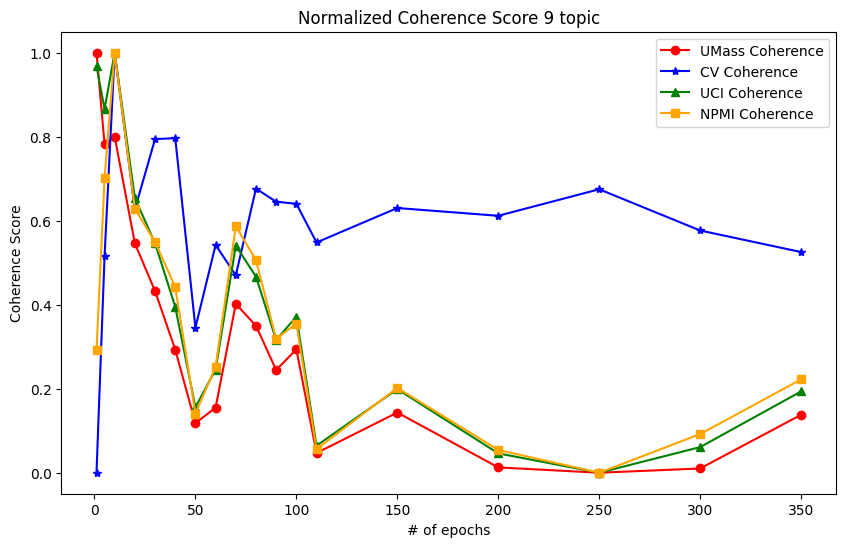

In [13]:
pretty_print(topic, epochs, coherence_umass, coherence_cv, coherence_uci, coherence_npmi)

In [14]:
#Training 10 topic con varie epoche 
coherence_umass = []
coherence_cv = []
coherence_uci = []
coherence_npmi = []

topic = 10
epochs = [1, 5, 10, 20, 30 ,40 ,50 ,60 ,70 ,80 ,90, 100, 110, 150, 200, 250, 300, 350]
for e in epochs:
    print(f"\n\nExecuting LDA with {topic} topics and {e} epochs")
    model, umass, cv, time_s, uci, npmi = execute_LDA(topic, tfidf_corpus, dictionary, e, name = "v2")
    coherence_umass.append(umass)
    coherence_cv.append(cv)
    coherence_uci.append(uci)
    coherence_npmi.append(npmi)
    print(f"Execution time: {(time_s/60):.3f} min")
    print(f"Coherence umass: {umass:.3f} e Coherence cv: {cv:.3f} e Coherence uci: {uci:.3f} e Coherence npmi: {npmi:.3f}")
    print_topic(topic, model)




Executing LDA with 10 topics and 1 epochs


ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/lucia/.local/lib/p

Execution time: 0.397 min
Coherence umass: -3.058 e Coherence cv: 0.496 e Coherence uci: -0.041 e Coherence npmi: 0.005

----- TOPIC -----
Topic1: "biden", "president", "great", "american", "live", "state", "today", "need", "week", "community"
Topic2: "trump", "biden", "people", "american", "republican", "writes", "time", "president", "democrat", "house"
Topic3: "biden", "right", "trump", "day", "republican", "american", "people", "state", "like", "court"
Topic4: "trump", "biden", "president", "donald", "republican", "election", "debate", "joe", "party", "want"
Topic5: "biden", "border", "people", "today", "american", "state", "day", "year", "happy", "trump"
Topic6: "elder", "community", "biden", "state", "american", "america", "people", "today", "election", "like"
Topic7: "american", "woman", "gun", "today", "right", "work", "fight", "violence", "year", "people"
Topic8: "cost", "american", "act", "job", "care", "family", "year", "republican", "million", "tax"
Topic9: "vote", "voting",

ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/lucia/.local/lib/p

Execution time: 0.965 min
Coherence umass: -5.680 e Coherence cv: 0.513 e Coherence uci: -1.779 e Coherence npmi: -0.025

----- TOPIC -----
Topic1: "join", "tune", "great", "thank", "live", "today", "discus", "week", "tonight", "town"
Topic2: "israel", "mccarthy", "war", "hamas", "ukraine", "kevin", "airline", "shutdown", "party", "biden"
Topic3: "perry", "johnson", "rubio", "warren", "capped", "rnc", "elizabeth", "reply", "mask", "god"
Topic4: "trump", "biden", "president", "republican", "joe", "election", "donald", "debate", "desantis", "gop"
Topic5: "border", "happy", "day", "biden", "ukraine", "illegal", "year", "crisis", "today", "southern"
Topic6: "elder", "bridge", "grant", "port", "maui", "county", "fire", "improvement", "highway", "wildfire"
Topic7: "woman", "right", "gun", "fight", "freedom", "abortion", "violence", "work", "today", "protect"
Topic8: "american", "job", "act", "cost", "family", "working", "economy", "year", "care", "tax"
Topic9: "vote", "election", "voting", "

ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/lucia/.local/lib/p

Execution time: 1.613 min
Coherence umass: -5.643 e Coherence cv: 0.524 e Coherence uci: -1.725 e Coherence npmi: -0.019

----- TOPIC -----
Topic1: "join", "tune", "debate", "great", "live", "tonight", "today", "discus", "thank", "watch"
Topic2: "israel", "war", "ukraine", "hamas", "menendez", "russia", "bob", "china", "shutdown", "biden"
Topic3: "perry", "warren", "rubio", "capped", "johnson", "marco", "elizabeth", "reply", "tester", "collaboration"
Topic4: "trump", "biden", "president", "joe", "donald", "republican", "house", "election", "desantis", "impeachment"
Topic5: "border", "happy", "day", "biden", "year", "world", "country", "today", "honor", "family"
Topic6: "bridge", "county", "fire", "maui", "grant", "wildfire", "local", "federal", "port", "area"
Topic7: "right", "woman", "gun", "fight", "work", "abortion", "freedom", "american", "violence", "people"
Topic8: "american", "job", "cost", "family", "economy", "act", "working", "worker", "tax", "year"
Topic9: "vote", "election"

ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/lucia/.local/lib/p

Execution time: 2.836 min
Coherence umass: -7.233 e Coherence cv: 0.569 e Coherence uci: -2.747 e Coherence npmi: -0.054

----- TOPIC -----
Topic1: "tune", "join", "tonight", "great", "live", "today", "debate", "thank", "week", "discus"
Topic2: "israel", "ingraham", "angle", "faa", "ukraine", "pet", "hamas", "war", "russia", "putin"
Topic3: "mask", "larry", "warren", "rubio", "perry", "johnson", "suck", "tester", "fantastic", "joke"
Topic4: "trump", "biden", "president", "joe", "donald", "republican", "house", "desantis", "election", "gop"
Topic5: "border", "migrant", "biden", "illegal", "happy", "crisis", "china", "ukraine", "wall", "southern"
Topic6: "elder", "bridge", "maui", "marijuana", "river", "storm", "wildfire", "improvement", "fire", "highway"
Topic7: "woman", "right", "gun", "freedom", "fight", "day", "today", "abortion", "life", "american"
Topic8: "american", "job", "act", "family", "cost", "economy", "year", "working", "care", "million"
Topic9: "vote", "election", "voting"

ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/lucia/.local/lib/p

Execution time: 3.943 min
Coherence umass: -7.227 e Coherence cv: 0.576 e Coherence uci: -2.693 e Coherence npmi: -0.053

----- TOPIC -----
Topic1: "join", "tune", "great", "tonight", "debate", "thank", "today", "live", "week", "discus"
Topic2: "menendez", "israel", "ingraham", "angle", "bob", "faa", "hamas", "flight", "pet", "administrator"
Topic3: "johnson", "rubio", "warren", "perry", "manchin", "suck", "tester", "fantastic", "charging", "reply"
Topic4: "trump", "biden", "president", "republican", "joe", "house", "donald", "desantis", "election", "gop"
Topic5: "border", "ukraine", "china", "biden", "war", "illegal", "migrant", "happy", "crisis", "russia"
Topic6: "elder", "bridge", "maui", "river", "grant", "fire", "marijuana", "wildfire", "storm", "improvement"
Topic7: "woman", "right", "freedom", "gun", "abortion", "fight", "life", "day", "today", "american"
Topic8: "american", "job", "act", "family", "care", "year", "working", "cost", "worker", "economy"
Topic9: "vote", "election"

ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/lucia/.local/lib/p

Execution time: 5.143 min
Coherence umass: -7.061 e Coherence cv: 0.546 e Coherence uci: -2.653 e Coherence npmi: -0.045

----- TOPIC -----
Topic1: "join", "great", "tune", "thank", "today", "tonight", "debate", "live", "discus", "week"
Topic2: "israel", "menendez", "ukraine", "putin", "russia", "bob", "hamas", "war", "iran", "faa"
Topic3: "johnson", "warren", "perry", "rubio", "charging", "elizabeth", "reply", "tester", "suck", "fantastic"
Topic4: "trump", "biden", "president", "joe", "house", "donald", "hunter", "election", "republican", "desantis"
Topic5: "border", "happy", "illegal", "migrant", "crisis", "southern", "biden", "wall", "fentanyl", "dakota"
Topic6: "elder", "bridge", "grant", "maui", "fire", "storm", "san", "improvement", "highway", "wildfire"
Topic7: "woman", "right", "gun", "freedom", "fight", "today", "life", "day", "abortion", "year"
Topic8: "american", "job", "act", "family", "cost", "working", "year", "worker", "economy", "million"
Topic9: "vote", "election", "vo

ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/lucia/.local/lib/p

Execution time: 6.242 min
Coherence umass: -7.108 e Coherence cv: 0.546 e Coherence uci: -2.766 e Coherence npmi: -0.050

----- TOPIC -----
Topic1: "join", "great", "tune", "today", "thank", "tonight", "live", "debate", "week", "discus"
Topic2: "israel", "ukraine", "russia", "menendez", "putin", "war", "bob", "hamas", "iran", "faa"
Topic3: "johnson", "warren", "perry", "rubio", "charging", "elizabeth", "tester", "reply", "suck", "fantastic"
Topic4: "trump", "biden", "president", "joe", "house", "donald", "desantis", "republican", "hunter", "election"
Topic5: "border", "migrant", "illegal", "crisis", "happy", "southern", "wall", "biden", "dakota", "fentanyl"
Topic6: "elder", "bridge", "maui", "grant", "storm", "fire", "san", "highway", "improvement", "wildfire"
Topic7: "woman", "right", "gun", "freedom", "life", "day", "fight", "today", "abortion", "year"
Topic8: "american", "job", "act", "family", "worker", "cost", "working", "year", "economy", "million"
Topic9: "vote", "election", "vo

ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/lucia/.local/lib/p

Execution time: 7.421 min
Coherence umass: -6.817 e Coherence cv: 0.559 e Coherence uci: -2.395 e Coherence npmi: -0.037

----- TOPIC -----
Topic1: "join", "tune", "great", "tonight", "debate", "live", "today", "thank", "week", "discus"
Topic2: "israel", "menendez", "putin", "bob", "hamas", "ukraine", "iran", "war", "lean", "faa"
Topic3: "warren", "perry", "rubio", "charging", "tester", "mask", "fantastic", "suck", "reply", "elizabeth"
Topic4: "trump", "biden", "president", "joe", "house", "donald", "desantis", "republican", "hunter", "election"
Topic5: "border", "illegal", "migrant", "crisis", "southern", "biden", "fentanyl", "wall", "immigrant", "city"
Topic6: "elder", "bridge", "maui", "grant", "storm", "weather", "fire", "improvement", "port", "highway"
Topic7: "woman", "right", "day", "today", "freedom", "gun", "year", "life", "fight", "happy"
Topic8: "american", "job", "act", "cost", "family", "economy", "working", "year", "million", "worker"
Topic9: "vote", "election", "race", "

ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/lucia/.local/lib/p

Execution time: 8.544 min
Coherence umass: -7.247 e Coherence cv: 0.545 e Coherence uci: -2.791 e Coherence npmi: -0.054

----- TOPIC -----
Topic1: "join", "great", "tune", "tonight", "debate", "today", "thank", "live", "week", "discus"
Topic2: "israel", "menendez", "bob", "ingraham", "angle", "hamas", "faa", "iran", "lean", "gaza"
Topic3: "johnson", "warren", "perry", "rubio", "tester", "charging", "suck", "fantastic", "reply", "elizabeth"
Topic4: "trump", "biden", "president", "joe", "donald", "house", "republican", "desantis", "election", "hunter"
Topic5: "border", "ukraine", "illegal", "migrant", "happy", "biden", "crisis", "russia", "southern", "war"
Topic6: "elder", "bridge", "maui", "grant", "river", "storm", "san", "wildfire", "fire", "weather"
Topic7: "woman", "right", "gun", "freedom", "abortion", "life", "fight", "today", "day", "year"
Topic8: "american", "job", "act", "worker", "family", "cost", "economy", "working", "year", "million"
Topic9: "vote", "election", "race", "vo

ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/lucia/.local/lib/p

Execution time: 10.216 min
Coherence umass: -7.292 e Coherence cv: 0.536 e Coherence uci: -2.827 e Coherence npmi: -0.052

----- TOPIC -----
Topic1: "join", "great", "tune", "today", "thank", "live", "tonight", "debate", "week", "discus"
Topic2: "israel", "menendez", "putin", "russia", "bob", "ukraine", "hamas", "war", "flight", "lean"
Topic3: "johnson", "warren", "rubio", "perry", "manchin", "tester", "charging", "mask", "reply", "vega"
Topic4: "trump", "biden", "president", "joe", "house", "donald", "hunter", "republican", "desantis", "impeachment"
Topic5: "border", "happy", "southern", "crisis", "illegal", "migrant", "biden", "fentanyl", "dakota", "wall"
Topic6: "elder", "bridge", "maui", "grant", "storm", "fire", "highway", "wildfire", "improvement", "port"
Topic7: "woman", "right", "gun", "freedom", "today", "life", "day", "abortion", "fight", "year"
Topic8: "american", "job", "act", "cost", "family", "worker", "working", "year", "economy", "million"
Topic9: "vote", "election", "r

ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/lucia/.local/lib/p

Execution time: 11.114 min
Coherence umass: -7.195 e Coherence cv: 0.545 e Coherence uci: -2.676 e Coherence npmi: -0.046

----- TOPIC -----
Topic1: "join", "tune", "great", "tonight", "today", "debate", "thank", "live", "week", "discus"
Topic2: "israel", "menendez", "bob", "hamas", "iran", "faa", "lean", "gaza", "aviation", "ingraham"
Topic3: "johnson", "warren", "perry", "rubio", "charging", "tester", "fantastic", "elizabeth", "reply", "mask"
Topic4: "trump", "biden", "president", "joe", "house", "donald", "hunter", "desantis", "republican", "election"
Topic5: "border", "ukraine", "migrant", "illegal", "crisis", "southern", "biden", "fentanyl", "russia", "wall"
Topic6: "elder", "bridge", "maui", "storm", "grant", "wildfire", "san", "fire", "improvement", "highway"
Topic7: "woman", "right", "freedom", "gun", "day", "today", "fight", "life", "year", "abortion"
Topic8: "american", "job", "act", "family", "cost", "working", "year", "worker", "economy", "million"
Topic9: "vote", "election

ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/lucia/.local/lib/p

Execution time: 12.186 min
Coherence umass: -7.209 e Coherence cv: 0.564 e Coherence uci: -2.673 e Coherence npmi: -0.053

----- TOPIC -----
Topic1: "join", "tune", "great", "tonight", "debate", "today", "thank", "live", "week", "discus"
Topic2: "menendez", "ingraham", "israel", "angle", "bob", "faa", "hamas", "lean", "pet", "administrator"
Topic3: "johnson", "warren", "perry", "rubio", "manchin", "tester", "suck", "elizabeth", "charging", "fantastic"
Topic4: "trump", "biden", "president", "republican", "joe", "house", "donald", "desantis", "democrat", "election"
Topic5: "border", "ukraine", "biden", "war", "china", "migrant", "illegal", "russia", "crisis", "southern"
Topic6: "elder", "bridge", "maui", "san", "grant", "storm", "fire", "river", "scene", "marijuana"
Topic7: "woman", "right", "day", "freedom", "gun", "abortion", "today", "life", "year", "fight"
Topic8: "american", "job", "act", "working", "family", "cost", "worker", "year", "economy", "care"
Topic9: "vote", "election", "r

ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/lucia/.local/lib/p

Execution time: 13.406 min
Coherence umass: -7.182 e Coherence cv: 0.559 e Coherence uci: -2.704 e Coherence npmi: -0.053

----- TOPIC -----
Topic1: "join", "tune", "great", "thank", "today", "tonight", "live", "debate", "week", "discus"
Topic2: "israel", "menendez", "hamas", "bob", "iran", "lean", "faa", "flight", "gaza", "joke"
Topic3: "johnson", "warren", "perry", "rubio", "manchin", "tester", "charging", "reply", "elizabeth", "suck"
Topic4: "trump", "biden", "president", "republican", "joe", "house", "democrat", "party", "donald", "people"
Topic5: "border", "happy", "illegal", "ukraine", "crisis", "migrant", "biden", "southern", "war", "russia"
Topic6: "elder", "bridge", "grant", "maui", "storm", "fire", "wildfire", "improvement", "highway", "flooding"
Topic7: "woman", "right", "freedom", "gun", "fight", "day", "today", "life", "american", "abortion"
Topic8: "american", "job", "act", "cost", "family", "working", "year", "economy", "worker", "million"
Topic9: "vote", "election", "ra

ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/lucia/.local/lib/p

Execution time: 18.181 min
Coherence umass: -7.028 e Coherence cv: 0.567 e Coherence uci: -2.514 e Coherence npmi: -0.042

----- TOPIC -----
Topic1: "join", "tune", "great", "tonight", "today", "debate", "live", "thank", "week", "discus"
Topic2: "lean", "faa", "hamas", "flight", "stock", "gaza", "bob", "palestinian", "airline", "ingraham"
Topic3: "mask", "johnson", "warren", "rubio", "perry", "fantastic", "bless", "tester", "reply", "suck"
Topic4: "trump", "biden", "president", "joe", "donald", "house", "hunter", "desantis", "republican", "impeachment"
Topic5: "border", "ukraine", "biden", "war", "china", "crisis", "illegal", "russia", "migrant", "southern"
Topic6: "elder", "bridge", "grant", "maui", "fire", "storm", "wildfire", "san", "improvement", "highway"
Topic7: "woman", "right", "gun", "day", "freedom", "today", "fight", "abortion", "life", "year"
Topic8: "american", "job", "act", "cost", "family", "working", "economy", "year", "million", "care"
Topic9: "vote", "election", "race

ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/lucia/.local/lib/p

Execution time: 23.990 min
Coherence umass: -7.015 e Coherence cv: 0.535 e Coherence uci: -2.525 e Coherence npmi: -0.041

----- TOPIC -----
Topic1: "join", "great", "tune", "today", "tonight", "live", "debate", "thank", "discus", "week"
Topic2: "israel", "bob", "menendez", "hamas", "iran", "lean", "faa", "gaza", "palestinian", "aviation"
Topic3: "johnson", "warren", "perry", "rubio", "manchin", "tester", "charging", "mask", "reply", "elizabeth"
Topic4: "trump", "biden", "president", "joe", "house", "hunter", "desantis", "donald", "republican", "election"
Topic5: "border", "ukraine", "crisis", "southern", "migrant", "illegal", "biden", "fentanyl", "war", "russia"
Topic6: "elder", "bridge", "maui", "grant", "wildfire", "storm", "san", "fire", "weather", "highway"
Topic7: "woman", "right", "day", "today", "freedom", "gun", "life", "year", "abortion", "family"
Topic8: "american", "job", "act", "cost", "family", "working", "economy", "year", "worker", "million"
Topic9: "vote", "election", 

ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/lucia/.local/lib/p

Execution time: 29.702 min
Coherence umass: -7.044 e Coherence cv: 0.544 e Coherence uci: -2.676 e Coherence npmi: -0.047

----- TOPIC -----
Topic1: "join", "great", "tune", "tonight", "debate", "today", "live", "thank", "week", "discus"
Topic2: "israel", "russia", "putin", "menendez", "bob", "ukraine", "war", "hamas", "iran", "faa"
Topic3: "johnson", "warren", "perry", "rubio", "mask", "tester", "reply", "elizabeth", "charging", "fantastic"
Topic4: "trump", "biden", "president", "joe", "house", "hunter", "donald", "desantis", "republican", "impeachment"
Topic5: "border", "migrant", "illegal", "crisis", "southern", "biden", "wall", "fentanyl", "secure", "dakota"
Topic6: "elder", "bridge", "maui", "grant", "storm", "wildfire", "san", "fire", "river", "area"
Topic7: "woman", "right", "gun", "day", "freedom", "today", "life", "abortion", "year", "fight"
Topic8: "american", "job", "act", "cost", "family", "worker", "economy", "working", "year", "million"
Topic9: "vote", "election", "race",

ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/lucia/.local/lib/p

Execution time: 35.811 min
Coherence umass: -7.278 e Coherence cv: 0.563 e Coherence uci: -2.720 e Coherence npmi: -0.048

----- TOPIC -----
Topic1: "join", "tune", "great", "tonight", "debate", "today", "live", "thank", "week", "discus"
Topic2: "israel", "menendez", "bob", "ingraham", "lean", "hamas", "angle", "faa", "iran", "gaza"
Topic3: "johnson", "warren", "perry", "manchin", "tester", "rubio", "charging", "suck", "reply", "fantastic"
Topic4: "trump", "biden", "president", "joe", "house", "donald", "hunter", "republican", "desantis", "impeachment"
Topic5: "border", "ukraine", "migrant", "biden", "crisis", "china", "illegal", "war", "russia", "southern"
Topic6: "elder", "bridge", "maui", "grant", "san", "river", "storm", "wildfire", "fire", "weather"
Topic7: "woman", "right", "day", "freedom", "gun", "today", "abortion", "life", "year", "fight"
Topic8: "american", "job", "act", "cost", "family", "economy", "working", "year", "care", "worker"
Topic9: "vote", "election", "race", "pri

ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/lucia/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/lucia/.local/lib/p

Execution time: 40.919 min
Coherence umass: -8.072 e Coherence cv: 0.525 e Coherence uci: -3.614 e Coherence npmi: -0.080

----- TOPIC -----
Topic1: "join", "tune", "great", "debate", "tonight", "today", "live", "thank", "discus", "week"
Topic2: "israel", "ukraine", "russia", "war", "menendez", "putin", "hamas", "iran", "bob", "flight"
Topic3: "warren", "johnson", "perry", "rubio", "manchin", "tester", "swamp", "charging", "reply", "joke"
Topic4: "trump", "biden", "president", "republican", "joe", "party", "democrat", "people", "house", "like"
Topic5: "border", "happy", "illegal", "migrant", "southern", "crisis", "dakota", "immigrant", "wall", "city"
Topic6: "elder", "bridge", "maui", "storm", "grant", "wildfire", "fire", "flooding", "port", "improvement"
Topic7: "woman", "right", "freedom", "day", "gun", "today", "american", "life", "fight", "country"
Topic8: "american", "job", "act", "working", "family", "cost", "year", "worker", "economy", "care"
Topic9: "vote", "election", "race", 

10 topic
Epochs:  [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 150, 200, 250, 300, 350]
Coherence score: [-3.0579957158865367, -5.6796278804884635, -5.643399515200417, -7.233068582077851, -7.226940287807414, -7.060635876797856, -7.108276950362908, -6.817081171343102, -7.247356846769843, -7.292250271400671, -7.195137463261186, -7.209103259674764, -7.182314598093019, -7.027663409411106, -7.01452887001345, -7.044381030629538, -7.27846262104885, -8.071968697031842] Max value:  -3.0579957158865367 all epoca: 1
coherence cv:  [0.4962759252602066, 0.5126599353480882, 0.5241187296580252, 0.5693181969093011, 0.5756946037422951, 0.5460286360531931, 0.545738640065187, 0.5591734895703511, 0.5447817836114353, 0.536189734063773, 0.5445248053465432, 0.5642900987385231, 0.5585115308488723, 0.5674662115937261, 0.5347509459501956, 0.5444931537728603, 0.5630398679118725, 0.524620546287811] Max value:  0.5756946037422951 all epoca: 30
coherence uci:  [-0.041371326980996416, -1.7793672385047556, -1

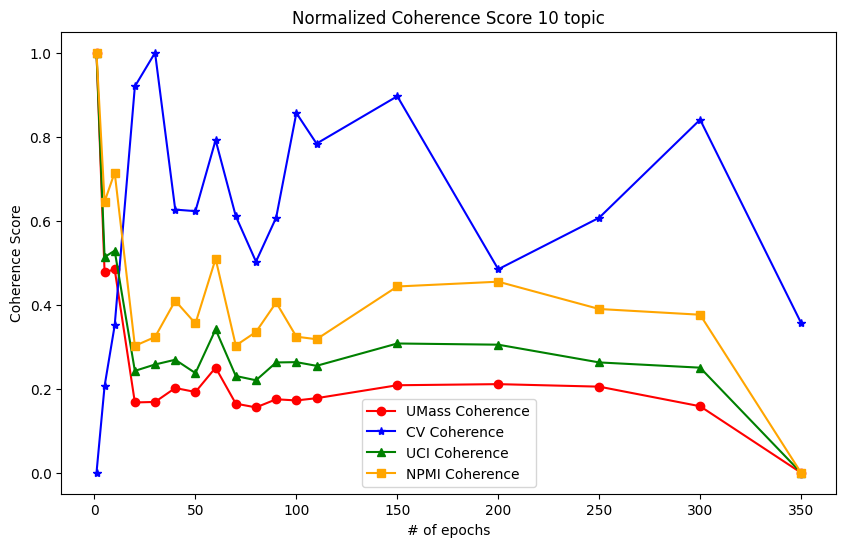

In [15]:
pretty_print(topic, epochs, coherence_umass, coherence_cv, coherence_uci, coherence_npmi)

In [113]:
#Training 11 topic con varie epoche 
coherence_umass = []
coherence_cv = []
coherence_uci = []
coherence_npmi = []

topic = 11
epochs = [1, 5, 10, 20, 30 ,40 ,50 ,60 ,70 ,80 ,90, 100, 110, 150, 200, 250, 300, 350]
for e in epochs:
    print(f"\n\nExecuting LDA with {topic} topics and {e} epochs")
    model, umass, cv, time_s, uci, npmi = execute_LDA(topic, tfidf_corpus, dictionary, e, name = "v2")
    coherence_umass.append(umass)
    coherence_cv.append(cv)
    coherence_uci.append(uci)
    coherence_npmi.append(npmi)
    print(f"Execution time: {(time_s/60):.3f} min")
    print(f"Coherence umass: {umass:.3f} e Coherence cv: {cv:.3f} e Coherence uci: {uci:.3f} e Coherence npmi: {npmi:.3f}")
    print_topic(topic, model)




Executing LDA with 11 topics and 1 epochs
Execution time: 0.392 min
Coherence umass: -3.529 e Coherence cv: 0.475 e Coherence uci: -0.391 e Coherence npmi: -0.006

----- TOPIC -----
Topic1: "town", "biden", "hall", "elder", "family", "american", "join", "drug", "care", "need"
Topic2: "trump", "biden", "angle", "president", "gun", "american", "republican", "people", "tonight", "need"
Topic3: "biden", "right", "republican", "people", "vote", "american", "mccarthy", "trump", "voting", "want"
Topic4: "trump", "biden", "republican", "president", "donald", "democrat", "time", "candidate", "election", "gop"
Topic5: "colorado", "biden", "american", "state", "year", "happy", "today", "border", "act", "people"
Topic6: "american", "job", "year", "president", "biden", "people", "work", "great", "state", "family"
Topic7: "job", "american", "energy", "work", "community", "woman", "act", "infrastructure", "year", "right"
Topic8: "biden", "president", "trump", "america", "year", "state", "time", "wa

11 topic
Epochs:  [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 150, 200, 250, 300, 350]
Coherence score: [-3.529003224100197, -6.147852839915023, -6.917308111665485, -7.446639296915394, -6.741692444752835, -7.468162160607542, -7.624848571304835, -7.640615448588508, -9.207151974527715, -8.108882535512008, -8.528799414083164, -8.57153694519643, -9.02698187280127, -8.677180260948578, -8.657214976027348, -8.682251027186352, -8.60963022114965, -8.615312285117339] Max value:  -3.529003224100197 all epoca: 1
coherence cv:  [0.47520089470965066, 0.5252538885957815, 0.5557854440511207, 0.5503620458511604, 0.5898339121821248, 0.5828597961733998, 0.5740016818773339, 0.5665400060969691, 0.5749806232356127, 0.585801657983784, 0.5720905917747925, 0.5800207242029946, 0.5663871734143535, 0.588691104942684, 0.5396378613260315, 0.5748261972950943, 0.5928829176184834, 0.5855008096951295] Max value:  0.5928829176184834 all epoca: 300
coherence uci:  [-0.3905398840280227, -2.1392418991089968, -2.65

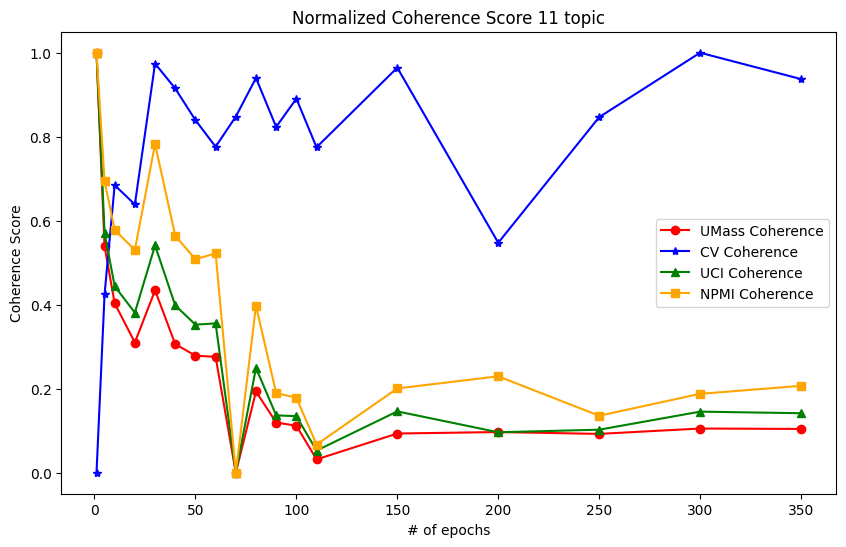

In [114]:
pretty_print(topic, epochs, coherence_umass, coherence_cv, coherence_uci, coherence_npmi)